In [16]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb
import multiprocessing as mp

env = gym.make('CartPole-v1')

In [17]:
class Tiling:
  def __init__(self, env, numTilings=8, numTiles=10):
    self.numTilings = numTilings
    self.numTiles = numTiles

    state, _ = env.reset()

    # Define limits
    cart_position_limit = 4.8
    pole_angle_limit = (24 * np.pi) / 180  # 24 degrees in radians
    cart_velocity_limit = 10
    pole_angular_velocity_limit = np.pi  # 3.1416 rad/s

    # Define low, high limits
    self.low = np.array([-cart_position_limit, -cart_velocity_limit, -pole_angle_limit, -pole_angular_velocity_limit])
    self.high = np.array([cart_position_limit, cart_velocity_limit, pole_angle_limit, pole_angular_velocity_limit])

    # Define offsets for tilings
    self.offsets = [
        (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
        for low, high in zip(self.low, self.high)
    ]

    # Create tilings
    self.tilings = self.createTilings()

  def getTilings(self):
    return self.tilings

  def createTilingGrid(self, low, high, bins, offsets):
    """ Create a single tiling grid """
    return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

  def createTilings(self):
    """ Create multiple tiling grids with offsets """
    tilings = []
    for i in range(self.numTilings):
        offsets_i = [offset[i] for offset in self.offsets]  # Pick correct offset for each tiling
        tilings.append(self.createTilingGrid(self.low, self.high, self.numTiles, offsets_i))
    return tilings

  def discretize(self, state):
    """ Convert continuous state into discrete indices across all tilings """
    discretized_indices = []
    for tiling in self.tilings:
        tile_indices = []
        for dim, bins in enumerate(tiling):
            tile_indices.append(np.digitize(state[dim], bins))  # Assign bin index for each dimension
        discretized_indices.append(tuple(tile_indices))
    return discretized_indices

In [18]:
class sarsaAgent:
  def __init__(self,env,alpha=0.1,gamma=0.99,epsilon_start=1.0,epsilon_decay=0.995,epsilon_min=0.0001,numTilings=2,numTiles=5,log_wandb=False):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon_start
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.numTilings = numTilings
    self.numTiles = numTiles
    self.log_wandb = log_wandb

    self.tiling = Tiling(env,numTilings,numTiles)
    self.numActions = self.env.action_space.n

    # Define feature representation using tile coding
    self.numFeatures = self.numTilings * self.numTiles** 4
    self.weights = np.zeros((self.numActions, self.numFeatures))  # Weights for each action

  def featureVector(self, state, action):
    """ Convert a continuous state into a binary feature vector. """
    discretized_indices = self.tiling.discretize(state)
    featureVector = np.zeros(self.numTilings * self.numTiles**4)

    for i, ds in enumerate(discretized_indices):
        index = sum(ds[d] * (self.numTiles**d) for d in range(len(ds)))  # Multi-dim index
        feature_index = i * self.numTiles**4 + index
        featureVector[feature_index] = 1  # Activate feature

    return featureVector

  def getQvalues(self,state,action):
    """ Approximates Q(s, a) = θ^T * φ(s, a) """
    featureVector = self.featureVector(state,action)
    return np.dot(self.weights[action], featureVector)

  def choose_epsilonGreedy_action(self,state):
    """ Chooses an action using ε-greedy policy. """
    if np.random.rand() < self.epsilon:
        return self.env.action_space.sample()  # Random action
    else:
        q_values = [self.getQvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)  # Best action

  def update(self,state,action,reward,next_state,next_action):
    """ SARSA update rule with linear function approximation """
    phi = self.featureVector(state, action)
    q_sa = self.getQvalues(state, action)
    q_next = self.getQvalues(next_state, next_action)

    td_target = reward + self.gamma * q_next
    td_error = td_target - q_sa
    self.weights[action] += (self.alpha/self.numTilings) * td_error * phi

  def train(self,num_episodes):
    episode_rewards = np.zeros(num_episodes)
    steps_to_completion = np.zeros(num_episodes)

    for i in tqdm(range(num_episodes)):
      totalReward = 0
      steps = 0

      state,_ = self.env.reset() #resetting the environment
      action = self.choose_epsilonGreedy_action(state)
      done = False

      while not done:
        next_state,reward,terminated,truncated,info = self.env.step(action)
        next_action = self.choose_epsilonGreedy_action(next_state)

        # Update weights using SARSA
        self.update(state, action, reward, next_state, next_action)

        state = next_state
        action = next_action

        totalReward += reward
        steps+=1

        done = terminated or truncated


      episode_rewards[i] = totalReward
      steps_to_completion[i] = steps

      #epsilon decay
      self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

      if i % 100 == 99:
        wandb.log({"episode": i+1, "episodic_return": episode_rewards[i]})
        avg_reward = np.mean(episode_rewards[max(0, i-100):i+1])
        print(f"Episode {i+1}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {self.epsilon:.4f}")

    return episode_rewards,steps_to_completion



In [19]:
class QLearningAgent:
  def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05,numTilings=8, numTiles=10,log_wandb=False):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.tau = tau_start
    self.tau_decay = tau_decay
    self.tau_min = tau_min
    self.log_wandb = log_wandb

    self.numTilings = numTilings
    self.numTiles = numTiles

    self.tiling = Tiling(env, numTilings, numTiles)
    self.numActions = self.env.action_space.n

    # Feature vector size: numTilings * numTiles * number_of_state_variables
    self.numFeatures = self.numTilings * self.numTiles ** self.env.observation_space.shape[0]
    # Weight vector for each action.
    self.weights = np.zeros((self.numActions, self.numFeatures))

  def featureVector(self, state, action):
    """ Convert a continuous state into a binary feature vector. """
    discretized_indices = self.tiling.discretize(state)
    featureVector = np.zeros(self.numTilings * self.numTiles**4)

    for i, ds in enumerate(discretized_indices):
        index = sum(ds[d] * (self.numTiles**d) for d in range(len(ds)))  # Multi-dim index
        feature_index = i * self.numTiles**4 + index
        featureVector[feature_index] = 1  # Activate feature

    return featureVector

  def getQvalue(self, state, action):
    """ Compute Q(s, a) = θ^T * φ(s, a). """
    phi = self.featureVector(state, action)
    return np.dot(self.weights[action], phi)

  def choose_action_softmax(self, state):
    """ Choose an action using a softmax (Boltzmann) policy. """
    q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
    # For numerical stability, subtract the maximum Q-value.
    exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
    probs = exp_values / np.sum(exp_values)
    return np.random.choice(self.numActions, p=probs)

  def update(self, state, action, reward, next_state):
    """ Q-learning update rule with linear function approximation. """
    phi = self.featureVector(state, action)
    q_sa = self.getQvalue(state, action)
    # For Q-learning, we use the maximum Q-value over next actions.
    q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
    td_target = reward + self.gamma * q_next_max
    td_error = td_target - q_sa
    self.weights[action] += (self.alpha/self.numTilings) * td_error * phi

  def train(self, num_episodes):
    episode_rewards = np.zeros(num_episodes)
    steps_to_completion = np.zeros(num_episodes)

    for i in tqdm(range(num_episodes)):
      totalReward = 0
      steps = 0
      state, _ = self.env.reset()
      done = False

      while not done:
          action = self.choose_action_softmax(state)
          next_state, reward, terminated, truncated, _ = self.env.step(action)
          done = terminated or truncated

          self.update(state, action, reward, next_state)

          state = next_state
          totalReward += reward
          steps += 1

      episode_rewards[i] = totalReward
      steps_to_completion[i] = steps

      # Decay the temperature
      self.tau = max(self.tau_min, self.tau * self.tau_decay)

      if i % 100 == 99:
        wandb.log({"episode": i+1, "episodic_return": episode_rewards[i]})
        avg_reward = np.mean(episode_rewards[max(0, i-100):i+1])
        print(f"Episode {i+1}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Tau: {self.tau:.4f}")

    return episode_rewards, steps_to_completion

In [52]:
def runSingleSarsaExperiment(env,seed,hyperparams,num_episodes,isWandb):
  np.random.seed(seed)
  env.reset(seed=seed)

  agent = sarsaAgent(env,
                     alpha=hyperparams.get("alpha",0.1),
                     gamma=hyperparams.get("gamma",0.99),
                     epsilon_start=hyperparams.get("epsilon_start",1.0),
                     epsilon_decay=hyperparams.get("epsilon_decay",0.995),
                     epsilon_min=hyperparams.get("epsilon_min",0.0001),
                     numTilings=hyperparams.get("numTilings",8),
                     numTiles=hyperparams.get("numTiles",10),
                     log_wandb=isWandb
                     )

  if isWandb==False:
      wandb.init(mode="disabled")
  rewards,steps = agent.train(num_episodes)
  return rewards

def runSingleQLearningExperiment(env,seed,hyperparams,num_episodes,isWandb):
  np.random.seed(seed)
  env.reset(seed=seed)

  agent = QLearningAgent(env,
                        alpha=hyperparams.get("alpha",0.1),
                        gamma=hyperparams.get("gamma",0.99),
                        tau_start=hyperparams.get("tau_start",1.0),
                        tau_decay=hyperparams.get("tau_decay",0.995),
                        tau_min=hyperparams.get("tau_min",0.0001),
                        numTilings=hyperparams.get("numTilings",8),
                        numTiles=hyperparams.get("numTiles",10),
                        log_wandb=isWandb
                        )

  if isWandb==False:
      wandb.init(mode="disabled")
  rewards,steps = agent.train(num_episodes)
  return rewards

def runMultipleSeeds(algorithm,env,hyperparams,num_episodes,isWandb):
  rewardArr = []
  seeds = [5,7]

  for seed in seeds:
    print(f"Running iteration {seed+1}")
    if algorithm == "sarsa":
      rewards = runSingleSarsaExperiment(env,seed,hyperparams,num_episodes,isWandb)
    else:
      rewards = runSingleQLearningExperiment(env,seed,hyperparams,num_episodes,isWandb)
    rewardArr.append(rewards)

  return rewardArr


In [21]:
def moving_average(data, window_size=100):
    """Compute running average using convolution."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m018 (cs24m018-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
sweep_config = {
    "method": "grid",
    "metric": {
        "name": "final_cumulative_regret",
        "goal": "minimize"
    },
    "parameters": {
        "alpha": {
            "values": [0.01,0.05, 0.1, 0.5]
        },
        "gamma": {
            "value": 0.99
        },
        "tau_start": {
            "value": 1.0
        },
        "tau_decay": {
            "values": [0.995, 0.999]
        },
        "tau_min": {
            "value": 0.001
        },
        "idx":{
            "values":[1,2,3]
        }
    }
}

In [ ]:
def sweep_main():
  run = wandb.init(project="RL_PA1")
  config = wandb.config

  wandb.run.name = f"alpha_{config.alpha}_gamma_{config.gamma}_tau_decay_{config.tau_decay}_idx_{config.idx}"
  wandb.run.save()

  tilesArr = [5,5,10]
  tilingsArr = [2,4,8]

  hyperparams = {
      "alpha": config.alpha,
      "gamma": config.gamma,
      "tau_start": config.tau_start,
      "tau_decay": config.tau_decay,
      "tau_min": config.tau_min,
      "numTilings": tilesArr[config.idx-1],
      "numTiles": tilingsArr[config.idx-1],
  }

  env = gym.make("CartPole-v1")

  num_episodes = 2500

  qLearning_rewards = runMultipleSeeds("QLearning", env, hyperparams, num_episodes,isWandb=True)
  mean_rewards = np.mean(qLearning_rewards, axis=0)

  # Compute cumulative regret. Assuming optimal reward per episode is 500.
  optimal_reward = 500
  instant_regret = optimal_reward - mean_rewards
  cumulative_regret = np.cumsum(instant_regret)

  # Log the final cumulative regret as the metric to minimize.
  final_cum_regret = cumulative_regret[-1]
  wandb.log({"final_cumulative_regret": final_cum_regret})

  # Optionally, log running average and plots.
  running_avg = moving_average(mean_rewards, window_size=10)
  wandb.log({"final_running_avg_reward": running_avg[-1]})

  print("Final Cumulative Regret:", final_cum_regret)
  run.finish()


sweep_id = wandb.sweep(sweep_config, project="RL_PA1")
wandb.agent(sweep_id, function=sweep_main)

Create sweep with ID: clfg21ii
Sweep URL: https://wandb.ai/cs24m018-iitmaana/RL_PA1/sweeps/clfg21ii


wandb: Agent Starting Run: yajbbf7l with config:
wandb: 	alpha: 0.01
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Running iteration 1


  5%|▍         | 121/2500 [00:01<00:21, 108.26it/s]

Episode 100/2500, Avg Reward (Last 100): 19.66, Tau: 0.6058


  9%|▉         | 224/2500 [00:02<00:18, 122.22it/s]

Episode 200/2500, Avg Reward (Last 100): 9.48, Tau: 0.3670


 13%|█▎        | 323/2500 [00:03<00:16, 130.82it/s]

Episode 300/2500, Avg Reward (Last 100): 9.34, Tau: 0.2223


 17%|█▋        | 418/2500 [00:04<00:15, 131.15it/s]

Episode 400/2500, Avg Reward (Last 100): 9.42, Tau: 0.1347


 21%|██        | 516/2500 [00:05<00:15, 127.61it/s]

Episode 500/2500, Avg Reward (Last 100): 9.18, Tau: 0.0816


 25%|██▍       | 623/2500 [00:05<00:14, 130.76it/s]

Episode 600/2500, Avg Reward (Last 100): 9.26, Tau: 0.0494


 28%|██▊       | 708/2500 [00:06<00:16, 111.51it/s]

Episode 700/2500, Avg Reward (Last 100): 9.26, Tau: 0.0299


 33%|███▎      | 816/2500 [00:07<00:21, 80.07it/s]

Episode 800/2500, Avg Reward (Last 100): 9.35, Tau: 0.0181


 37%|███▋      | 915/2500 [00:09<00:18, 83.59it/s]

Episode 900/2500, Avg Reward (Last 100): 9.26, Tau: 0.0110


 40%|████      | 1009/2500 [00:10<00:19, 76.30it/s]

Episode 1000/2500, Avg Reward (Last 100): 9.27, Tau: 0.0067


 45%|████▍     | 1124/2500 [00:11<00:11, 124.77it/s]

Episode 1100/2500, Avg Reward (Last 100): 9.40, Tau: 0.0040


 49%|████▉     | 1223/2500 [00:12<00:10, 124.69it/s]

Episode 1200/2500, Avg Reward (Last 100): 9.41, Tau: 0.0024


 53%|█████▎    | 1321/2500 [00:12<00:09, 125.87it/s]

Episode 1300/2500, Avg Reward (Last 100): 9.36, Tau: 0.0015


 57%|█████▋    | 1420/2500 [00:13<00:07, 136.02it/s]

Episode 1400/2500, Avg Reward (Last 100): 9.38, Tau: 0.0010


 61%|██████    | 1518/2500 [00:14<00:07, 133.10it/s]

Episode 1500/2500, Avg Reward (Last 100): 9.26, Tau: 0.0010


 65%|██████▍   | 1613/2500 [00:15<00:07, 116.97it/s]

Episode 1600/2500, Avg Reward (Last 100): 9.24, Tau: 0.0010


 69%|██████▊   | 1717/2500 [00:16<00:06, 116.41it/s]

Episode 1700/2500, Avg Reward (Last 100): 9.34, Tau: 0.0010


 72%|███████▏  | 1808/2500 [00:16<00:07, 92.08it/s]

Episode 1800/2500, Avg Reward (Last 100): 9.42, Tau: 0.0010


 77%|███████▋  | 1919/2500 [00:17<00:04, 129.07it/s]

Episode 1900/2500, Avg Reward (Last 100): 9.34, Tau: 0.0010


 81%|████████  | 2026/2500 [00:18<00:03, 125.51it/s]

Episode 2000/2500, Avg Reward (Last 100): 9.51, Tau: 0.0010


 84%|████████▍ | 2107/2500 [00:19<00:03, 125.36it/s]

Episode 2100/2500, Avg Reward (Last 100): 9.39, Tau: 0.0010


 89%|████████▊ | 2218/2500 [00:20<00:02, 128.94it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.32, Tau: 0.0010


 92%|█████████▏| 2311/2500 [00:21<00:02, 79.23it/s]

Episode 2300/2500, Avg Reward (Last 100): 9.45, Tau: 0.0010


 96%|█████████▋| 2409/2500 [00:22<00:01, 77.34it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.31, Tau: 0.0010


100%|██████████| 2500/2500 [00:23<00:00, 104.66it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.44, Tau: 0.0010
Final Cumulative Regret: 1225604.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▃▆▆▆▆▃▃▃▃▆▃█▆▃▆▁▃▆▆▃▁▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1225604.0
final_running_avg_reward,9.4


wandb: Agent Starting Run: vmor56gx with config:
wandb: 	alpha: 0.01
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  5%|▍         | 117/2500 [00:02<00:28, 83.34it/s]

Episode 100/2500, Avg Reward (Last 100): 21.87, Tau: 0.9048


  8%|▊         | 212/2500 [00:02<00:19, 119.17it/s]

Episode 200/2500, Avg Reward (Last 100): 9.87, Tau: 0.8186


 12%|█▏        | 311/2500 [00:04<00:25, 86.74it/s]

Episode 300/2500, Avg Reward (Last 100): 9.34, Tau: 0.7407


 16%|█▋        | 409/2500 [00:05<00:26, 78.59it/s]

Episode 400/2500, Avg Reward (Last 100): 9.42, Tau: 0.6702


 21%|██        | 513/2500 [00:06<00:25, 77.33it/s]

Episode 500/2500, Avg Reward (Last 100): 9.18, Tau: 0.6064


 25%|██▍       | 624/2500 [00:07<00:15, 120.51it/s]

Episode 600/2500, Avg Reward (Last 100): 9.26, Tau: 0.5486


 29%|██▊       | 718/2500 [00:08<00:15, 115.79it/s]

Episode 700/2500, Avg Reward (Last 100): 9.26, Tau: 0.4964


 33%|███▎      | 826/2500 [00:09<00:13, 128.18it/s]

Episode 800/2500, Avg Reward (Last 100): 9.35, Tau: 0.4491


 37%|███▋      | 922/2500 [00:10<00:12, 131.07it/s]

Episode 900/2500, Avg Reward (Last 100): 9.26, Tau: 0.4064


 41%|████      | 1021/2500 [00:10<00:11, 130.45it/s]

Episode 1000/2500, Avg Reward (Last 100): 9.27, Tau: 0.3677


 45%|████▍     | 1116/2500 [00:11<00:11, 115.99it/s]

Episode 1100/2500, Avg Reward (Last 100): 9.40, Tau: 0.3327


 49%|████▊     | 1214/2500 [00:12<00:12, 106.99it/s]

Episode 1200/2500, Avg Reward (Last 100): 9.41, Tau: 0.3010


 53%|█████▎    | 1320/2500 [00:13<00:09, 127.44it/s]

Episode 1300/2500, Avg Reward (Last 100): 9.36, Tau: 0.2724


 57%|█████▋    | 1415/2500 [00:14<00:08, 125.65it/s]

Episode 1400/2500, Avg Reward (Last 100): 9.38, Tau: 0.2464


 61%|██████    | 1526/2500 [00:14<00:07, 128.77it/s]

Episode 1500/2500, Avg Reward (Last 100): 9.26, Tau: 0.2230


 65%|██████▍   | 1616/2500 [00:15<00:07, 116.23it/s]

Episode 1600/2500, Avg Reward (Last 100): 9.24, Tau: 0.2017


 68%|██████▊   | 1712/2500 [00:16<00:07, 110.75it/s]

Episode 1700/2500, Avg Reward (Last 100): 9.34, Tau: 0.1825


 73%|███████▎  | 1815/2500 [00:17<00:08, 79.12it/s]

Episode 1800/2500, Avg Reward (Last 100): 9.42, Tau: 0.1652


 77%|███████▋  | 1913/2500 [00:19<00:07, 78.39it/s]

Episode 1900/2500, Avg Reward (Last 100): 9.34, Tau: 0.1494


 80%|████████  | 2012/2500 [00:20<00:06, 75.37it/s]

Episode 2000/2500, Avg Reward (Last 100): 9.51, Tau: 0.1352


 85%|████████▍ | 2124/2500 [00:21<00:03, 117.75it/s]

Episode 2100/2500, Avg Reward (Last 100): 9.39, Tau: 0.1223


 88%|████████▊ | 2207/2500 [00:22<00:02, 130.31it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.32, Tau: 0.1107


 93%|█████████▎| 2315/2500 [00:23<00:01, 115.77it/s]

Episode 2300/2500, Avg Reward (Last 100): 9.45, Tau: 0.1001


 97%|█████████▋| 2421/2500 [00:23<00:00, 120.86it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.31, Tau: 0.0906


100%|██████████| 2500/2500 [00:24<00:00, 101.60it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.44, Tau: 0.0820
Final Cumulative Regret: 1225344.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▆▃▆▆▆▆▃▃▃▃▆▃█▆▃▆▁▃▆▆▃▁▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1225344.0
final_running_avg_reward,9.4


wandb: Agent Starting Run: 15vrsjmq with config:
wandb: 	alpha: 0.01
wandb: 	gamma: 0.99
wandb: 	idx: 2
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 105/2500 [00:03<01:07, 35.35it/s]

Episode 100/2500, Avg Reward (Last 100): 30.95, Tau: 0.6058


  8%|▊         | 206/2500 [00:05<00:52, 43.93it/s]

Episode 200/2500, Avg Reward (Last 100): 31.61, Tau: 0.3670


 12%|█▏        | 307/2500 [00:07<00:51, 42.55it/s]

Episode 300/2500, Avg Reward (Last 100): 28.97, Tau: 0.2223


 16%|█▌        | 406/2500 [00:10<01:14, 28.10it/s]

Episode 400/2500, Avg Reward (Last 100): 29.62, Tau: 0.1347


 20%|██        | 503/2500 [00:14<01:16, 26.22it/s]

Episode 500/2500, Avg Reward (Last 100): 28.59, Tau: 0.0816


 24%|██▍       | 608/2500 [00:17<00:43, 43.10it/s]

Episode 600/2500, Avg Reward (Last 100): 28.96, Tau: 0.0494


 28%|██▊       | 703/2500 [00:19<00:47, 38.18it/s]

Episode 700/2500, Avg Reward (Last 100): 28.65, Tau: 0.0299


 32%|███▏      | 805/2500 [00:22<00:37, 44.73it/s]

Episode 800/2500, Avg Reward (Last 100): 29.21, Tau: 0.0181


 36%|███▌      | 906/2500 [00:24<00:36, 43.25it/s]

Episode 900/2500, Avg Reward (Last 100): 29.27, Tau: 0.0110


 40%|████      | 1002/2500 [00:27<00:57, 26.22it/s]

Episode 1000/2500, Avg Reward (Last 100): 28.87, Tau: 0.0067


 44%|████▍     | 1106/2500 [00:30<00:31, 44.06it/s]

Episode 1100/2500, Avg Reward (Last 100): 29.15, Tau: 0.0040


 48%|████▊     | 1206/2500 [00:32<00:29, 44.31it/s]

Episode 1200/2500, Avg Reward (Last 100): 29.60, Tau: 0.0024


 52%|█████▏    | 1306/2500 [00:35<00:28, 41.62it/s]

Episode 1300/2500, Avg Reward (Last 100): 29.09, Tau: 0.0015


 56%|█████▋    | 1407/2500 [00:37<00:25, 42.05it/s]

Episode 1400/2500, Avg Reward (Last 100): 29.35, Tau: 0.0010


 60%|██████    | 1503/2500 [00:40<00:38, 25.94it/s]

Episode 1500/2500, Avg Reward (Last 100): 29.85, Tau: 0.0010


 64%|██████▍   | 1606/2500 [00:43<00:21, 41.26it/s]

Episode 1600/2500, Avg Reward (Last 100): 30.77, Tau: 0.0010


 68%|██████▊   | 1705/2500 [00:46<00:20, 39.12it/s]

Episode 1700/2500, Avg Reward (Last 100): 31.56, Tau: 0.0010


 72%|███████▏  | 1807/2500 [00:48<00:17, 39.19it/s]

Episode 1800/2500, Avg Reward (Last 100): 32.06, Tau: 0.0010


 76%|███████▌  | 1905/2500 [00:51<00:15, 38.02it/s]

Episode 1900/2500, Avg Reward (Last 100): 31.90, Tau: 0.0010


 80%|████████  | 2002/2500 [00:55<00:22, 22.27it/s]

Episode 2000/2500, Avg Reward (Last 100): 31.96, Tau: 0.0010


 84%|████████▍ | 2103/2500 [00:57<00:09, 40.99it/s]

Episode 2100/2500, Avg Reward (Last 100): 31.67, Tau: 0.0010


 88%|████████▊ | 2203/2500 [01:00<00:07, 37.47it/s]

Episode 2200/2500, Avg Reward (Last 100): 31.30, Tau: 0.0010


 92%|█████████▏| 2307/2500 [01:03<00:04, 41.02it/s]

Episode 2300/2500, Avg Reward (Last 100): 32.28, Tau: 0.0010


 96%|█████████▌| 2406/2500 [01:05<00:02, 36.70it/s]

Episode 2400/2500, Avg Reward (Last 100): 31.59, Tau: 0.0010


100%|██████████| 2500/2500 [01:09<00:00, 35.84it/s]

Episode 2500/2500, Avg Reward (Last 100): 31.93, Tau: 0.0010
Final Cumulative Regret: 1174109.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▃▅█▆▃▁▁▂▂▄▃▆▅▄▅▁▅▇▅▂▂▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,33
final_cumulative_regret,1174109.0
final_running_avg_reward,31.9


wandb: Agent Starting Run: figy84qg with config:
wandb: 	alpha: 0.01
wandb: 	gamma: 0.99
wandb: 	idx: 2
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 104/2500 [00:02<01:38, 24.21it/s]

Episode 100/2500, Avg Reward (Last 100): 28.98, Tau: 0.9048


  8%|▊         | 205/2500 [00:06<00:52, 44.01it/s]

Episode 200/2500, Avg Reward (Last 100): 30.86, Tau: 0.8186


 12%|█▏        | 305/2500 [00:08<00:50, 43.32it/s]

Episode 300/2500, Avg Reward (Last 100): 28.44, Tau: 0.7407


 16%|█▋        | 407/2500 [00:11<00:51, 40.81it/s]

Episode 400/2500, Avg Reward (Last 100): 29.21, Tau: 0.6702


 20%|██        | 507/2500 [00:13<00:47, 41.62it/s]

Episode 500/2500, Avg Reward (Last 100): 29.24, Tau: 0.6064


 24%|██▍       | 603/2500 [00:15<01:08, 27.63it/s]

Episode 600/2500, Avg Reward (Last 100): 30.30, Tau: 0.5486


 28%|██▊       | 706/2500 [00:19<00:47, 37.70it/s]

Episode 700/2500, Avg Reward (Last 100): 31.16, Tau: 0.4964


 32%|███▏      | 805/2500 [00:22<00:43, 39.28it/s]

Episode 800/2500, Avg Reward (Last 100): 31.79, Tau: 0.4491


 36%|███▌      | 904/2500 [00:24<00:41, 38.19it/s]

Episode 900/2500, Avg Reward (Last 100): 32.46, Tau: 0.4064


 40%|████      | 1006/2500 [00:27<00:39, 37.57it/s]

Episode 1000/2500, Avg Reward (Last 100): 32.47, Tau: 0.3677


 44%|████▍     | 1103/2500 [00:31<01:02, 22.24it/s]

Episode 1100/2500, Avg Reward (Last 100): 33.40, Tau: 0.3327


 48%|████▊     | 1208/2500 [00:34<00:33, 38.83it/s]

Episode 1200/2500, Avg Reward (Last 100): 33.81, Tau: 0.3010


 52%|█████▏    | 1306/2500 [00:37<00:31, 37.49it/s]

Episode 1300/2500, Avg Reward (Last 100): 33.78, Tau: 0.2724


 56%|█████▌    | 1402/2500 [00:40<00:36, 30.14it/s]

Episode 1400/2500, Avg Reward (Last 100): 39.15, Tau: 0.2464


 60%|██████    | 1500/2500 [00:46<01:58,  8.44it/s]

Episode 1500/2500, Avg Reward (Last 100): 61.53, Tau: 0.2230


 64%|██████▍   | 1600/2500 [00:58<02:52,  5.22it/s]

Episode 1600/2500, Avg Reward (Last 100): 139.96, Tau: 0.2017


 68%|██████▊   | 1701/2500 [01:11<02:24,  5.52it/s]

Episode 1700/2500, Avg Reward (Last 100): 141.53, Tau: 0.1825


 72%|███████▏  | 1801/2500 [01:23<01:21,  8.63it/s]

Episode 1800/2500, Avg Reward (Last 100): 141.36, Tau: 0.1652


 76%|███████▌  | 1901/2500 [01:35<01:10,  8.53it/s]

Episode 1900/2500, Avg Reward (Last 100): 140.32, Tau: 0.1494


 80%|████████  | 2001/2500 [01:48<00:57,  8.65it/s]

Episode 2000/2500, Avg Reward (Last 100): 139.60, Tau: 0.1352


 84%|████████▍ | 2101/2500 [02:01<00:44,  9.04it/s]

Episode 2100/2500, Avg Reward (Last 100): 140.76, Tau: 0.1223


 88%|████████▊ | 2201/2500 [02:13<00:33,  8.96it/s]

Episode 2200/2500, Avg Reward (Last 100): 139.01, Tau: 0.1107


 92%|█████████▏| 2301/2500 [02:26<00:20,  9.56it/s]

Episode 2300/2500, Avg Reward (Last 100): 141.59, Tau: 0.1001


 96%|█████████▌| 2401/2500 [02:38<00:11,  8.57it/s]

Episode 2400/2500, Avg Reward (Last 100): 132.22, Tau: 0.0906


100%|██████████| 2500/2500 [02:50<00:00, 14.62it/s]

Episode 2500/2500, Avg Reward (Last 100): 140.70, Tau: 0.0820
Final Cumulative Regret: 1059609.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▇█▇▇██▇▇█▇▇
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,135
final_cumulative_regret,1059609.0
final_running_avg_reward,141.1


wandb: Agent Starting Run: 9up28jlb with config:
wandb: 	alpha: 0.01
wandb: 	gamma: 0.99
wandb: 	idx: 3
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 102/2500 [00:10<03:38, 10.99it/s]

Episode 100/2500, Avg Reward (Last 100): 25.60, Tau: 0.6058


  8%|▊         | 202/2500 [00:26<04:08,  9.24it/s]

Episode 200/2500, Avg Reward (Last 100): 43.57, Tau: 0.3670


 12%|█▏        | 301/2500 [00:41<04:50,  7.57it/s]

Episode 300/2500, Avg Reward (Last 100): 43.80, Tau: 0.2223


 16%|█▌        | 400/2500 [00:57<04:55,  7.10it/s]

Episode 400/2500, Avg Reward (Last 100): 46.17, Tau: 0.1347


 20%|██        | 500/2500 [01:13<05:55,  5.63it/s]

Episode 500/2500, Avg Reward (Last 100): 44.41, Tau: 0.0816


 24%|██▍       | 602/2500 [01:32<04:25,  7.14it/s]

Episode 600/2500, Avg Reward (Last 100): 46.87, Tau: 0.0494


 28%|██▊       | 700/2500 [01:49<04:28,  6.71it/s]

Episode 700/2500, Avg Reward (Last 100): 49.24, Tau: 0.0299


 32%|███▏      | 801/2500 [02:09<03:55,  7.22it/s]

Episode 800/2500, Avg Reward (Last 100): 52.79, Tau: 0.0181


 36%|███▌      | 901/2500 [02:31<04:02,  6.60it/s]

Episode 900/2500, Avg Reward (Last 100): 53.64, Tau: 0.0110


 40%|████      | 1001/2500 [02:49<03:21,  7.42it/s]

Episode 1000/2500, Avg Reward (Last 100): 54.81, Tau: 0.0067


 44%|████▍     | 1101/2500 [03:13<03:45,  6.20it/s]

Episode 1100/2500, Avg Reward (Last 100): 60.87, Tau: 0.0040


 48%|████▊     | 1201/2500 [03:34<03:49,  5.66it/s]

Episode 1200/2500, Avg Reward (Last 100): 64.82, Tau: 0.0024


 52%|█████▏    | 1301/2500 [04:00<03:34,  5.60it/s]

Episode 1300/2500, Avg Reward (Last 100): 71.30, Tau: 0.0015


 56%|█████▌    | 1400/2500 [04:30<05:28,  3.35it/s]

Episode 1400/2500, Avg Reward (Last 100): 87.66, Tau: 0.0010


 60%|██████    | 1500/2500 [05:10<04:47,  3.48it/s]

Episode 1500/2500, Avg Reward (Last 100): 110.97, Tau: 0.0010


 64%|██████▍   | 1600/2500 [05:52<05:03,  2.97it/s]

Episode 1600/2500, Avg Reward (Last 100): 116.31, Tau: 0.0010


 68%|██████▊   | 1700/2500 [06:35<04:20,  3.07it/s]

Episode 1700/2500, Avg Reward (Last 100): 123.51, Tau: 0.0010


 72%|███████▏  | 1800/2500 [07:19<03:53,  3.00it/s]

Episode 1800/2500, Avg Reward (Last 100): 126.77, Tau: 0.0010


 76%|███████▌  | 1900/2500 [08:02<03:47,  2.64it/s]

Episode 1900/2500, Avg Reward (Last 100): 126.27, Tau: 0.0010


 80%|████████  | 2000/2500 [08:49<07:53,  1.05it/s]

Episode 2000/2500, Avg Reward (Last 100): 127.23, Tau: 0.0010


 84%|████████▍ | 2100/2500 [09:33<03:20,  2.00it/s]

Episode 2100/2500, Avg Reward (Last 100): 127.33, Tau: 0.0010


 88%|████████▊ | 2200/2500 [10:17<01:53,  2.64it/s]

Episode 2200/2500, Avg Reward (Last 100): 126.00, Tau: 0.0010


 92%|█████████▏| 2300/2500 [11:02<01:15,  2.66it/s]

Episode 2300/2500, Avg Reward (Last 100): 131.83, Tau: 0.0010


 96%|█████████▌| 2400/2500 [11:46<00:36,  2.71it/s]

Episode 2400/2500, Avg Reward (Last 100): 126.35, Tau: 0.0010


100%|██████████| 2500/2500 [12:30<00:00,  3.33it/s]

Episode 2500/2500, Avg Reward (Last 100): 128.43, Tau: 0.0010
Final Cumulative Regret: 1038264.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▂▃▂▄▃▂▂▂▂▃▃▄▇▅▇▆▆█▇▆▆█▆▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,123
final_cumulative_regret,1038264.0
final_running_avg_reward,132.9


wandb: Agent Starting Run: dutx26j8 with config:
wandb: 	alpha: 0.01
wandb: 	gamma: 0.99
wandb: 	idx: 3
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 99/2500 [00:06<02:25, 16.49it/s]

Episode 100/2500, Avg Reward (Last 100): 22.47, Tau: 0.9048


  8%|▊         | 201/2500 [00:25<08:11,  4.68it/s]

Episode 200/2500, Avg Reward (Last 100): 45.45, Tau: 0.8186


 12%|█▏        | 301/2500 [00:45<06:12,  5.90it/s]

Episode 300/2500, Avg Reward (Last 100): 59.15, Tau: 0.7407


 16%|█▌        | 400/2500 [01:09<06:45,  5.18it/s]

Episode 400/2500, Avg Reward (Last 100): 64.67, Tau: 0.6702


 20%|██        | 500/2500 [01:31<08:07,  4.10it/s]

Episode 500/2500, Avg Reward (Last 100): 65.82, Tau: 0.6064


 24%|██▍       | 601/2500 [01:59<07:05,  4.46it/s]

Episode 600/2500, Avg Reward (Last 100): 77.45, Tau: 0.5486


 28%|██▊       | 700/2500 [02:35<09:31,  3.15it/s]

Episode 700/2500, Avg Reward (Last 100): 99.59, Tau: 0.4964


 32%|███▏      | 800/2500 [03:18<09:54,  2.86it/s]

Episode 800/2500, Avg Reward (Last 100): 120.96, Tau: 0.4491


 36%|███▌      | 900/2500 [04:02<09:22,  2.84it/s]

Episode 900/2500, Avg Reward (Last 100): 126.86, Tau: 0.4064


 40%|████      | 1000/2500 [04:46<08:17,  3.01it/s]

Episode 1000/2500, Avg Reward (Last 100): 126.17, Tau: 0.3677


 44%|████▍     | 1100/2500 [05:35<20:17,  1.15it/s]

Episode 1100/2500, Avg Reward (Last 100): 134.07, Tau: 0.3327


 48%|████▊     | 1200/2500 [06:21<08:10,  2.65it/s]

Episode 1200/2500, Avg Reward (Last 100): 133.30, Tau: 0.3010


 52%|█████▏    | 1300/2500 [07:06<07:27,  2.68it/s]

Episode 1300/2500, Avg Reward (Last 100): 131.13, Tau: 0.2724


 56%|█████▌    | 1400/2500 [07:54<14:00,  1.31it/s]

Episode 1400/2500, Avg Reward (Last 100): 134.15, Tau: 0.2464


 60%|██████    | 1500/2500 [08:41<06:56,  2.40it/s]

Episode 1500/2500, Avg Reward (Last 100): 130.32, Tau: 0.2230


 64%|██████▍   | 1600/2500 [09:25<05:30,  2.72it/s]

Episode 1600/2500, Avg Reward (Last 100): 127.87, Tau: 0.2017


 68%|██████▊   | 1700/2500 [10:10<04:29,  2.97it/s]

Episode 1700/2500, Avg Reward (Last 100): 130.26, Tau: 0.1825


 72%|███████▏  | 1800/2500 [11:00<10:33,  1.11it/s]

Episode 1800/2500, Avg Reward (Last 100): 134.03, Tau: 0.1652


 76%|███████▌  | 1900/2500 [11:45<04:11,  2.39it/s]

Episode 1900/2500, Avg Reward (Last 100): 131.69, Tau: 0.1494


 80%|████████  | 2000/2500 [12:30<03:06,  2.68it/s]

Episode 2000/2500, Avg Reward (Last 100): 132.85, Tau: 0.1352


 84%|████████▍ | 2100/2500 [13:16<02:27,  2.72it/s]

Episode 2100/2500, Avg Reward (Last 100): 132.26, Tau: 0.1223


 88%|████████▊ | 2200/2500 [14:04<02:17,  2.19it/s]

Episode 2200/2500, Avg Reward (Last 100): 131.16, Tau: 0.1107


 92%|█████████▏| 2300/2500 [14:51<01:20,  2.47it/s]

Episode 2300/2500, Avg Reward (Last 100): 136.82, Tau: 0.1001


 96%|█████████▌| 2400/2500 [15:36<00:36,  2.74it/s]

Episode 2400/2500, Avg Reward (Last 100): 130.48, Tau: 0.0906


100%|██████████| 2500/2500 [16:25<00:00,  2.54it/s]

Episode 2500/2500, Avg Reward (Last 100): 132.80, Tau: 0.0820
Final Cumulative Regret: 970779.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▃▂▅▄▅▅▅▅▆▅██▆▆▅▆▇▆▅▅█▅▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,130
final_cumulative_regret,970779
final_running_avg_reward,136.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k0b9vrqr with config:
wandb: 	alpha: 0.05
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  5%|▍         | 122/2500 [00:01<00:18, 127.79it/s]

Episode 100/2500, Avg Reward (Last 100): 10.34, Tau: 0.6058


  9%|▉         | 219/2500 [00:01<00:18, 121.70it/s]

Episode 200/2500, Avg Reward (Last 100): 9.47, Tau: 0.3670


 13%|█▎        | 323/2500 [00:02<00:19, 113.79it/s]

Episode 300/2500, Avg Reward (Last 100): 9.34, Tau: 0.2223


 17%|█▋        | 423/2500 [00:03<00:18, 109.41it/s]

Episode 400/2500, Avg Reward (Last 100): 9.42, Tau: 0.1347


 20%|██        | 508/2500 [00:04<00:24, 82.81it/s]

Episode 500/2500, Avg Reward (Last 100): 9.18, Tau: 0.0816


 24%|██▍       | 611/2500 [00:06<00:24, 76.45it/s]

Episode 600/2500, Avg Reward (Last 100): 9.26, Tau: 0.0494


 28%|██▊       | 710/2500 [00:07<00:23, 77.25it/s]

Episode 700/2500, Avg Reward (Last 100): 9.26, Tau: 0.0299


 33%|███▎      | 813/2500 [00:08<00:14, 115.15it/s]

Episode 800/2500, Avg Reward (Last 100): 9.35, Tau: 0.0181


 37%|███▋      | 924/2500 [00:09<00:12, 129.46it/s]

Episode 900/2500, Avg Reward (Last 100): 9.26, Tau: 0.0110


 41%|████      | 1014/2500 [00:10<00:13, 110.46it/s]

Episode 1000/2500, Avg Reward (Last 100): 9.27, Tau: 0.0067


 45%|████▍     | 1116/2500 [00:10<00:12, 109.53it/s]

Episode 1100/2500, Avg Reward (Last 100): 9.40, Tau: 0.0040


 49%|████▉     | 1224/2500 [00:11<00:10, 124.57it/s]

Episode 1200/2500, Avg Reward (Last 100): 9.41, Tau: 0.0024


 53%|█████▎    | 1323/2500 [00:12<00:08, 132.05it/s]

Episode 1300/2500, Avg Reward (Last 100): 9.36, Tau: 0.0015


 57%|█████▋    | 1421/2500 [00:13<00:08, 130.07it/s]

Episode 1400/2500, Avg Reward (Last 100): 9.38, Tau: 0.0010


 61%|██████    | 1516/2500 [00:14<00:07, 128.90it/s]

Episode 1500/2500, Avg Reward (Last 100): 9.26, Tau: 0.0010


 64%|██████▍   | 1612/2500 [00:14<00:07, 114.27it/s]

Episode 1600/2500, Avg Reward (Last 100): 9.24, Tau: 0.0010


 69%|██████▊   | 1718/2500 [00:15<00:06, 112.72it/s]

Episode 1700/2500, Avg Reward (Last 100): 9.34, Tau: 0.0010


 73%|███████▎  | 1827/2500 [00:16<00:05, 126.39it/s]

Episode 1800/2500, Avg Reward (Last 100): 9.42, Tau: 0.0010


 77%|███████▋  | 1920/2500 [00:17<00:04, 128.84it/s]

Episode 1900/2500, Avg Reward (Last 100): 9.34, Tau: 0.0010


 81%|████████  | 2014/2500 [00:18<00:05, 81.32it/s]

Episode 2000/2500, Avg Reward (Last 100): 9.51, Tau: 0.0010


 84%|████████▍ | 2110/2500 [00:19<00:04, 79.80it/s]

Episode 2100/2500, Avg Reward (Last 100): 9.39, Tau: 0.0010


 88%|████████▊ | 2208/2500 [00:21<00:03, 73.67it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.32, Tau: 0.0010


 93%|█████████▎| 2314/2500 [00:22<00:01, 122.07it/s]

Episode 2300/2500, Avg Reward (Last 100): 9.45, Tau: 0.0010


 97%|█████████▋| 2423/2500 [00:22<00:00, 114.80it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.31, Tau: 0.0010


100%|██████████| 2500/2500 [00:23<00:00, 105.94it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.44, Tau: 0.0010
Final Cumulative Regret: 1226537.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▃▆▆▆▆▃▃▃▃▆▃█▆▃▆▁▃▆▆▃▁▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1226537.0
final_running_avg_reward,9.4


wandb: Agent Starting Run: 4cej7k43 with config:
wandb: 	alpha: 0.05
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 111/2500 [00:01<00:30, 77.22it/s]

Episode 100/2500, Avg Reward (Last 100): 10.64, Tau: 0.9048


  8%|▊         | 206/2500 [00:02<00:32, 71.64it/s]

Episode 200/2500, Avg Reward (Last 100): 9.47, Tau: 0.8186


 13%|█▎        | 318/2500 [00:04<00:26, 83.74it/s]

Episode 300/2500, Avg Reward (Last 100): 9.34, Tau: 0.7407


 17%|█▋        | 421/2500 [00:05<00:16, 123.53it/s]

Episode 400/2500, Avg Reward (Last 100): 9.42, Tau: 0.6702


 21%|██        | 516/2500 [00:05<00:15, 126.97it/s]

Episode 500/2500, Avg Reward (Last 100): 9.18, Tau: 0.6064


 25%|██▍       | 622/2500 [00:06<00:15, 123.79it/s]

Episode 600/2500, Avg Reward (Last 100): 9.26, Tau: 0.5486


 29%|██▉       | 720/2500 [00:07<00:15, 117.24it/s]

Episode 700/2500, Avg Reward (Last 100): 9.26, Tau: 0.4964


 33%|███▎      | 815/2500 [00:08<00:15, 108.44it/s]

Episode 800/2500, Avg Reward (Last 100): 9.35, Tau: 0.4491


 37%|███▋      | 922/2500 [00:09<00:11, 132.07it/s]

Episode 900/2500, Avg Reward (Last 100): 9.26, Tau: 0.4064


 41%|████      | 1018/2500 [00:10<00:11, 126.22it/s]

Episode 1000/2500, Avg Reward (Last 100): 9.27, Tau: 0.3677


 45%|████▍     | 1124/2500 [00:10<00:11, 125.08it/s]

Episode 1100/2500, Avg Reward (Last 100): 9.40, Tau: 0.3327


 49%|████▉     | 1220/2500 [00:11<00:10, 119.52it/s]

Episode 1200/2500, Avg Reward (Last 100): 9.41, Tau: 0.3010


 53%|█████▎    | 1316/2500 [00:12<00:10, 111.80it/s]

Episode 1300/2500, Avg Reward (Last 100): 9.36, Tau: 0.2724


 57%|█████▋    | 1417/2500 [00:13<00:09, 116.97it/s]

Episode 1400/2500, Avg Reward (Last 100): 9.38, Tau: 0.2464


 61%|██████    | 1520/2500 [00:14<00:07, 125.84it/s]

Episode 1500/2500, Avg Reward (Last 100): 9.26, Tau: 0.2230


 64%|██████▍   | 1611/2500 [00:15<00:10, 82.87it/s]

Episode 1600/2500, Avg Reward (Last 100): 9.24, Tau: 0.2017


 68%|██████▊   | 1710/2500 [00:16<00:09, 81.09it/s]

Episode 1700/2500, Avg Reward (Last 100): 9.34, Tau: 0.1825


 72%|███████▏  | 1809/2500 [00:17<00:09, 72.81it/s]

Episode 1800/2500, Avg Reward (Last 100): 9.42, Tau: 0.1652


 77%|███████▋  | 1921/2500 [00:18<00:04, 121.03it/s]

Episode 1900/2500, Avg Reward (Last 100): 9.34, Tau: 0.1494


 81%|████████  | 2015/2500 [00:19<00:03, 122.14it/s]

Episode 2000/2500, Avg Reward (Last 100): 9.51, Tau: 0.1352


 84%|████████▍ | 2108/2500 [00:20<00:03, 103.01it/s]

Episode 2100/2500, Avg Reward (Last 100): 9.39, Tau: 0.1223


 89%|████████▊ | 2218/2500 [00:21<00:02, 130.75it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.32, Tau: 0.1107


 93%|█████████▎| 2313/2500 [00:22<00:01, 117.55it/s]

Episode 2300/2500, Avg Reward (Last 100): 9.45, Tau: 0.1001


 97%|█████████▋| 2425/2500 [00:23<00:00, 126.43it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.31, Tau: 0.0906


100%|██████████| 2500/2500 [00:23<00:00, 105.46it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.44, Tau: 0.0820
Final Cumulative Regret: 1226507.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▃▆▆▆▆▃▃▃▃▆▃█▆▃▆▁▃▆▆▃▁▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1226507.0
final_running_avg_reward,9.4


wandb: Agent Starting Run: 1gpp6bz8 with config:
wandb: 	alpha: 0.05
wandb: 	gamma: 0.99
wandb: 	idx: 2
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 102/2500 [00:03<02:15, 17.68it/s]

Episode 100/2500, Avg Reward (Last 100): 36.27, Tau: 0.6058


  8%|▊         | 201/2500 [00:18<06:39,  5.75it/s]

Episode 200/2500, Avg Reward (Last 100): 178.30, Tau: 0.3670


 12%|█▏        | 300/2500 [00:37<08:58,  4.08it/s]

Episode 300/2500, Avg Reward (Last 100): 210.68, Tau: 0.2223


 16%|█▌        | 401/2500 [00:55<05:37,  6.22it/s]

Episode 400/2500, Avg Reward (Last 100): 200.29, Tau: 0.1347


 20%|██        | 501/2500 [01:12<05:01,  6.63it/s]

Episode 500/2500, Avg Reward (Last 100): 201.96, Tau: 0.0816


 24%|██▍       | 601/2500 [01:29<05:02,  6.28it/s]

Episode 600/2500, Avg Reward (Last 100): 198.22, Tau: 0.0494


 28%|██▊       | 701/2500 [01:49<04:58,  6.03it/s]

Episode 700/2500, Avg Reward (Last 100): 206.57, Tau: 0.0299


 32%|███▏      | 801/2500 [02:06<04:07,  6.86it/s]

Episode 800/2500, Avg Reward (Last 100): 207.50, Tau: 0.0181


 36%|███▌      | 901/2500 [02:24<04:22,  6.09it/s]

Episode 900/2500, Avg Reward (Last 100): 200.56, Tau: 0.0110


 40%|████      | 1001/2500 [02:43<03:25,  7.29it/s]

Episode 1000/2500, Avg Reward (Last 100): 205.84, Tau: 0.0067


 44%|████▍     | 1101/2500 [03:00<03:53,  5.99it/s]

Episode 1100/2500, Avg Reward (Last 100): 197.50, Tau: 0.0040


 48%|████▊     | 1201/2500 [03:17<03:22,  6.41it/s]

Episode 1200/2500, Avg Reward (Last 100): 201.06, Tau: 0.0024


 52%|█████▏    | 1301/2500 [03:36<03:11,  6.26it/s]

Episode 1300/2500, Avg Reward (Last 100): 201.80, Tau: 0.0015


 56%|█████▌    | 1401/2500 [03:53<02:56,  6.23it/s]

Episode 1400/2500, Avg Reward (Last 100): 199.59, Tau: 0.0010


 60%|██████    | 1501/2500 [04:11<02:36,  6.36it/s]

Episode 1500/2500, Avg Reward (Last 100): 199.93, Tau: 0.0010


 64%|██████▍   | 1601/2500 [04:29<03:16,  4.58it/s]

Episode 1600/2500, Avg Reward (Last 100): 199.88, Tau: 0.0010


 68%|██████▊   | 1701/2500 [04:47<01:57,  6.80it/s]

Episode 1700/2500, Avg Reward (Last 100): 203.34, Tau: 0.0010


 72%|███████▏  | 1801/2500 [05:05<01:55,  6.05it/s]

Episode 1800/2500, Avg Reward (Last 100): 205.85, Tau: 0.0010


 76%|███████▌  | 1901/2500 [05:24<02:00,  4.98it/s]

Episode 1900/2500, Avg Reward (Last 100): 202.01, Tau: 0.0010


 80%|████████  | 2001/2500 [05:41<01:21,  6.13it/s]

Episode 2000/2500, Avg Reward (Last 100): 200.59, Tau: 0.0010


 84%|████████▍ | 2101/2500 [05:59<00:56,  7.05it/s]

Episode 2100/2500, Avg Reward (Last 100): 205.71, Tau: 0.0010


 88%|████████▊ | 2201/2500 [06:18<00:57,  5.24it/s]

Episode 2200/2500, Avg Reward (Last 100): 207.18, Tau: 0.0010


 92%|█████████▏| 2301/2500 [06:35<00:29,  6.75it/s]

Episode 2300/2500, Avg Reward (Last 100): 201.44, Tau: 0.0010


 96%|█████████▌| 2401/2500 [06:53<00:17,  5.71it/s]

Episode 2400/2500, Avg Reward (Last 100): 200.53, Tau: 0.0010


100%|██████████| 2500/2500 [07:11<00:00,  5.79it/s]

Episode 2500/2500, Avg Reward (Last 100): 202.07, Tau: 0.0010
Final Cumulative Regret: 762478.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁█▃▆▃▆▄▂▅▃▆▆▂▆▇▆▃▆▂▆▂▃▄▆▅
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,218
final_cumulative_regret,762478
final_running_avg_reward,214.4


wandb: Agent Starting Run: 57ecf7bz with config:
wandb: 	alpha: 0.05
wandb: 	gamma: 0.99
wandb: 	idx: 2
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 101/2500 [00:04<03:05, 12.91it/s]

Episode 100/2500, Avg Reward (Last 100): 33.84, Tau: 0.9048


  8%|▊         | 201/2500 [00:21<06:08,  6.24it/s]

Episode 200/2500, Avg Reward (Last 100): 194.11, Tau: 0.8186


 12%|█▏        | 301/2500 [00:40<06:21,  5.76it/s]

Episode 300/2500, Avg Reward (Last 100): 218.58, Tau: 0.7407


 16%|█▌        | 401/2500 [01:01<07:25,  4.71it/s]

Episode 400/2500, Avg Reward (Last 100): 234.12, Tau: 0.6702


 20%|██        | 501/2500 [01:21<05:38,  5.90it/s]

Episode 500/2500, Avg Reward (Last 100): 229.97, Tau: 0.6064


 24%|██▍       | 601/2500 [01:42<05:42,  5.54it/s]

Episode 600/2500, Avg Reward (Last 100): 222.89, Tau: 0.5486


 28%|██▊       | 701/2500 [02:01<05:26,  5.50it/s]

Episode 700/2500, Avg Reward (Last 100): 225.18, Tau: 0.4964


 32%|███▏      | 801/2500 [02:24<04:11,  6.77it/s]

Episode 800/2500, Avg Reward (Last 100): 238.20, Tau: 0.4491


 36%|███▌      | 901/2500 [02:44<04:30,  5.91it/s]

Episode 900/2500, Avg Reward (Last 100): 225.81, Tau: 0.4064


 40%|████      | 1001/2500 [03:05<03:44,  6.69it/s]

Episode 1000/2500, Avg Reward (Last 100): 230.62, Tau: 0.3677


 44%|████▍     | 1100/2500 [03:25<04:31,  5.17it/s]

Episode 1100/2500, Avg Reward (Last 100): 232.19, Tau: 0.3327


 48%|████▊     | 1201/2500 [03:46<03:50,  5.63it/s]

Episode 1200/2500, Avg Reward (Last 100): 228.76, Tau: 0.3010


 52%|█████▏    | 1300/2500 [04:07<06:31,  3.07it/s]

Episode 1300/2500, Avg Reward (Last 100): 237.51, Tau: 0.2724


 56%|█████▌    | 1401/2500 [04:28<02:53,  6.33it/s]

Episode 1400/2500, Avg Reward (Last 100): 225.14, Tau: 0.2464


 60%|██████    | 1500/2500 [04:47<04:05,  4.08it/s]

Episode 1500/2500, Avg Reward (Last 100): 224.76, Tau: 0.2230


 64%|██████▍   | 1600/2500 [05:07<02:51,  5.26it/s]

Episode 1600/2500, Avg Reward (Last 100): 220.36, Tau: 0.2017


 68%|██████▊   | 1701/2500 [05:27<02:06,  6.33it/s]

Episode 1700/2500, Avg Reward (Last 100): 227.34, Tau: 0.1825


 72%|███████▏  | 1800/2500 [05:48<02:11,  5.31it/s]

Episode 1800/2500, Avg Reward (Last 100): 224.83, Tau: 0.1652


 76%|███████▌  | 1900/2500 [06:07<01:39,  6.06it/s]

Episode 1900/2500, Avg Reward (Last 100): 220.43, Tau: 0.1494


 80%|████████  | 2001/2500 [06:28<01:35,  5.24it/s]

Episode 2000/2500, Avg Reward (Last 100): 223.16, Tau: 0.1352


 84%|████████▍ | 2101/2500 [06:47<01:05,  6.11it/s]

Episode 2100/2500, Avg Reward (Last 100): 231.83, Tau: 0.1223


 88%|████████▊ | 2201/2500 [07:08<00:49,  6.04it/s]

Episode 2200/2500, Avg Reward (Last 100): 220.81, Tau: 0.1107


 92%|█████████▏| 2301/2500 [07:27<00:32,  6.21it/s]

Episode 2300/2500, Avg Reward (Last 100): 224.31, Tau: 0.1001


 96%|█████████▌| 2401/2500 [07:48<00:18,  5.24it/s]

Episode 2400/2500, Avg Reward (Last 100): 220.80, Tau: 0.0906


100%|██████████| 2500/2500 [08:08<00:00,  5.12it/s]

Episode 2500/2500, Avg Reward (Last 100): 237.18, Tau: 0.0820
Final Cumulative Regret: 704413.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▇▄▆▅▅▄▃▅▄▇▅▇▅▆▆▃▆▅▆▃▃▅▆█
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,322
final_cumulative_regret,704413
final_running_avg_reward,248


wandb: Agent Starting Run: pc1o11df with config:
wandb: 	alpha: 0.05
wandb: 	gamma: 0.99
wandb: 	idx: 3
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 101/2500 [00:16<06:09,  6.50it/s]

Episode 100/2500, Avg Reward (Last 100): 44.88, Tau: 0.6058


  8%|▊         | 200/2500 [00:40<08:33,  4.48it/s]

Episode 200/2500, Avg Reward (Last 100): 62.20, Tau: 0.3670


 12%|█▏        | 300/2500 [01:22<14:42,  2.49it/s]

Episode 300/2500, Avg Reward (Last 100): 116.87, Tau: 0.2223


 16%|█▌        | 400/2500 [02:08<13:20,  2.62it/s]

Episode 400/2500, Avg Reward (Last 100): 132.17, Tau: 0.1347


 20%|██        | 500/2500 [02:53<14:59,  2.22it/s]

Episode 500/2500, Avg Reward (Last 100): 130.09, Tau: 0.0816


 24%|██▍       | 600/2500 [03:41<15:26,  2.05it/s]

Episode 600/2500, Avg Reward (Last 100): 131.81, Tau: 0.0494


 28%|██▊       | 700/2500 [04:27<10:55,  2.75it/s]

Episode 700/2500, Avg Reward (Last 100): 132.62, Tau: 0.0299


 32%|███▏      | 800/2500 [05:14<10:21,  2.74it/s]

Episode 800/2500, Avg Reward (Last 100): 135.45, Tau: 0.0181


 36%|███▌      | 900/2500 [06:04<12:10,  2.19it/s]

Episode 900/2500, Avg Reward (Last 100): 135.46, Tau: 0.0110


 40%|████      | 1000/2500 [06:50<08:59,  2.78it/s]

Episode 1000/2500, Avg Reward (Last 100): 133.62, Tau: 0.0067


 44%|████▍     | 1100/2500 [07:42<13:02,  1.79it/s]

Episode 1100/2500, Avg Reward (Last 100): 140.91, Tau: 0.0040


 48%|████▊     | 1200/2500 [08:30<08:22,  2.59it/s]

Episode 1200/2500, Avg Reward (Last 100): 141.41, Tau: 0.0024


 52%|█████▏    | 1300/2500 [09:21<10:58,  1.82it/s]

Episode 1300/2500, Avg Reward (Last 100): 140.22, Tau: 0.0015


 56%|█████▌    | 1400/2500 [10:10<07:16,  2.52it/s]

Episode 1400/2500, Avg Reward (Last 100): 143.90, Tau: 0.0010


 60%|██████    | 1500/2500 [11:01<07:17,  2.28it/s]

Episode 1500/2500, Avg Reward (Last 100): 139.35, Tau: 0.0010


 64%|██████▍   | 1600/2500 [11:48<05:54,  2.54it/s]

Episode 1600/2500, Avg Reward (Last 100): 137.61, Tau: 0.0010


 68%|██████▊   | 1700/2500 [12:39<07:33,  1.77it/s]

Episode 1700/2500, Avg Reward (Last 100): 139.60, Tau: 0.0010


 72%|███████▏  | 1800/2500 [13:28<04:25,  2.64it/s]

Episode 1800/2500, Avg Reward (Last 100): 144.98, Tau: 0.0010


 76%|███████▌  | 1900/2500 [14:19<04:33,  2.19it/s]

Episode 1900/2500, Avg Reward (Last 100): 142.25, Tau: 0.0010


 80%|████████  | 2000/2500 [15:08<03:20,  2.50it/s]

Episode 2000/2500, Avg Reward (Last 100): 143.21, Tau: 0.0010


 84%|████████▍ | 2100/2500 [16:00<02:43,  2.44it/s]

Episode 2100/2500, Avg Reward (Last 100): 142.78, Tau: 0.0010


 88%|████████▊ | 2200/2500 [16:52<04:27,  1.12it/s]

Episode 2200/2500, Avg Reward (Last 100): 142.95, Tau: 0.0010


 92%|█████████▏| 2300/2500 [17:42<01:29,  2.25it/s]

Episode 2300/2500, Avg Reward (Last 100): 148.97, Tau: 0.0010


 96%|█████████▌| 2400/2500 [18:34<00:42,  2.33it/s]

Episode 2400/2500, Avg Reward (Last 100): 142.87, Tau: 0.0010


100%|██████████| 2500/2500 [19:27<00:00,  2.14it/s]

Episode 2500/2500, Avg Reward (Last 100): 145.14, Tau: 0.0010
Final Cumulative Regret: 920863.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▃▅▅█▅▅▄▅▅▅▅▇▇▅▅▄▅▇▆▅▅█▅▅
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,141
final_cumulative_regret,920863
final_running_avg_reward,145.7


wandb: Agent Starting Run: 445nh81i with config:
wandb: 	alpha: 0.05
wandb: 	gamma: 0.99
wandb: 	idx: 3
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 100/2500 [00:18<18:51,  2.12it/s]

Episode 100/2500, Avg Reward (Last 100): 42.12, Tau: 0.9048


  8%|▊         | 200/2500 [00:41<10:00,  3.83it/s]

Episode 200/2500, Avg Reward (Last 100): 68.37, Tau: 0.8186


 12%|█▏        | 300/2500 [01:25<13:15,  2.76it/s]

Episode 300/2500, Avg Reward (Last 100): 121.77, Tau: 0.7407


 16%|█▌        | 400/2500 [02:13<21:59,  1.59it/s]

Episode 400/2500, Avg Reward (Last 100): 128.50, Tau: 0.6702


 20%|██        | 500/2500 [02:58<15:22,  2.17it/s]

Episode 500/2500, Avg Reward (Last 100): 129.41, Tau: 0.6064


 24%|██▍       | 600/2500 [03:43<11:48,  2.68it/s]

Episode 600/2500, Avg Reward (Last 100): 129.36, Tau: 0.5486


 28%|██▊       | 700/2500 [04:28<10:47,  2.78it/s]

Episode 700/2500, Avg Reward (Last 100): 130.16, Tau: 0.4964


 32%|███▏      | 800/2500 [05:17<13:14,  2.14it/s]

Episode 800/2500, Avg Reward (Last 100): 131.94, Tau: 0.4491


 36%|███▌      | 900/2500 [06:03<09:53,  2.70it/s]

Episode 900/2500, Avg Reward (Last 100): 131.53, Tau: 0.4064


 40%|████      | 1000/2500 [06:48<08:51,  2.82it/s]

Episode 1000/2500, Avg Reward (Last 100): 131.32, Tau: 0.3677


 44%|████▍     | 1100/2500 [07:39<09:04,  2.57it/s]

Episode 1100/2500, Avg Reward (Last 100): 138.50, Tau: 0.3327


 48%|████▊     | 1200/2500 [08:26<08:05,  2.68it/s]

Episode 1200/2500, Avg Reward (Last 100): 137.69, Tau: 0.3010


 52%|█████▏    | 1300/2500 [09:16<10:07,  1.98it/s]

Episode 1300/2500, Avg Reward (Last 100): 135.59, Tau: 0.2724


 56%|█████▌    | 1400/2500 [10:04<07:06,  2.58it/s]

Episode 1400/2500, Avg Reward (Last 100): 138.81, Tau: 0.2464


 60%|██████    | 1500/2500 [10:53<16:02,  1.04it/s]

Episode 1500/2500, Avg Reward (Last 100): 133.64, Tau: 0.2230


 64%|██████▍   | 1600/2500 [11:38<05:45,  2.60it/s]

Episode 1600/2500, Avg Reward (Last 100): 131.91, Tau: 0.2017


 68%|██████▊   | 1700/2500 [12:25<04:46,  2.79it/s]

Episode 1700/2500, Avg Reward (Last 100): 134.26, Tau: 0.1825


 72%|███████▏  | 1800/2500 [13:15<05:31,  2.11it/s]

Episode 1800/2500, Avg Reward (Last 100): 137.75, Tau: 0.1652


 76%|███████▌  | 1900/2500 [14:02<04:11,  2.39it/s]

Episode 1900/2500, Avg Reward (Last 100): 135.39, Tau: 0.1494


 80%|████████  | 2000/2500 [14:52<06:34,  1.27it/s]

Episode 2000/2500, Avg Reward (Last 100): 136.68, Tau: 0.1352


 84%|████████▍ | 2100/2500 [15:39<02:31,  2.64it/s]

Episode 2100/2500, Avg Reward (Last 100): 135.88, Tau: 0.1223


 88%|████████▊ | 2200/2500 [16:26<01:47,  2.79it/s]

Episode 2200/2500, Avg Reward (Last 100): 135.12, Tau: 0.1107


 92%|█████████▏| 2300/2500 [17:17<01:26,  2.31it/s]

Episode 2300/2500, Avg Reward (Last 100): 141.11, Tau: 0.1001


 96%|█████████▌| 2400/2500 [18:03<00:38,  2.59it/s]

Episode 2400/2500, Avg Reward (Last 100): 134.83, Tau: 0.0906


100%|██████████| 2500/2500 [18:54<00:00,  2.20it/s]

Episode 2500/2500, Avg Reward (Last 100): 136.64, Tau: 0.0820
Final Cumulative Regret: 931199.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▃▅▅█▅▅▄▅▅▅▅▇▇▅▅▄▅▇▅▅▄█▅▅
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,132
final_cumulative_regret,931199
final_running_avg_reward,138.3


wandb: Agent Starting Run: fj3rg78l with config:
wandb: 	alpha: 0.1
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  5%|▍         | 113/2500 [00:01<00:31, 75.31it/s]

Episode 100/2500, Avg Reward (Last 100): 9.60, Tau: 0.6058


  8%|▊         | 209/2500 [00:02<00:29, 77.81it/s]

Episode 200/2500, Avg Reward (Last 100): 9.47, Tau: 0.3670


 13%|█▎        | 314/2500 [00:04<00:24, 89.44it/s]

Episode 300/2500, Avg Reward (Last 100): 9.34, Tau: 0.2223


 17%|█▋        | 423/2500 [00:04<00:17, 121.58it/s]

Episode 400/2500, Avg Reward (Last 100): 9.42, Tau: 0.1347


 21%|██        | 517/2500 [00:05<00:16, 117.26it/s]

Episode 500/2500, Avg Reward (Last 100): 9.18, Tau: 0.0816


 25%|██▍       | 622/2500 [00:06<00:15, 120.41it/s]

Episode 600/2500, Avg Reward (Last 100): 9.26, Tau: 0.0494


 29%|██▊       | 715/2500 [00:07<00:14, 121.82it/s]

Episode 700/2500, Avg Reward (Last 100): 9.26, Tau: 0.0299


 33%|███▎      | 821/2500 [00:08<00:13, 125.27it/s]

Episode 800/2500, Avg Reward (Last 100): 9.35, Tau: 0.0181


 37%|███▋      | 922/2500 [00:09<00:13, 117.29it/s]

Episode 900/2500, Avg Reward (Last 100): 9.26, Tau: 0.0110


 41%|████      | 1017/2500 [00:10<00:13, 106.13it/s]

Episode 1000/2500, Avg Reward (Last 100): 9.27, Tau: 0.0067


 45%|████▍     | 1119/2500 [00:10<00:11, 122.73it/s]

Episode 1100/2500, Avg Reward (Last 100): 9.40, Tau: 0.0040


 49%|████▉     | 1223/2500 [00:11<00:10, 122.13it/s]

Episode 1200/2500, Avg Reward (Last 100): 9.41, Tau: 0.0024


 53%|█████▎    | 1323/2500 [00:12<00:09, 118.40it/s]

Episode 1300/2500, Avg Reward (Last 100): 9.36, Tau: 0.0015


 57%|█████▋    | 1423/2500 [00:13<00:08, 124.55it/s]

Episode 1400/2500, Avg Reward (Last 100): 9.38, Tau: 0.0010


 61%|██████    | 1516/2500 [00:14<00:12, 80.27it/s]

Episode 1500/2500, Avg Reward (Last 100): 9.26, Tau: 0.0010


 64%|██████▍   | 1610/2500 [00:15<00:10, 82.86it/s]

Episode 1600/2500, Avg Reward (Last 100): 9.24, Tau: 0.0010


 68%|██████▊   | 1709/2500 [00:17<00:10, 72.86it/s]

Episode 1700/2500, Avg Reward (Last 100): 9.34, Tau: 0.0010


 73%|███████▎  | 1820/2500 [00:18<00:06, 107.67it/s]

Episode 1800/2500, Avg Reward (Last 100): 9.42, Tau: 0.0010


 76%|███████▌  | 1906/2500 [00:19<00:06, 90.88it/s] 

Episode 1900/2500, Avg Reward (Last 100): 9.34, Tau: 0.0010


 81%|████████  | 2024/2500 [00:20<00:04, 111.10it/s]

Episode 2000/2500, Avg Reward (Last 100): 9.51, Tau: 0.0010


 85%|████████▍ | 2113/2500 [00:21<00:03, 105.13it/s]

Episode 2100/2500, Avg Reward (Last 100): 9.39, Tau: 0.0010


 89%|████████▊ | 2218/2500 [00:22<00:02, 127.69it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.32, Tau: 0.0010


 93%|█████████▎| 2323/2500 [00:22<00:01, 118.87it/s]

Episode 2300/2500, Avg Reward (Last 100): 9.45, Tau: 0.0010


 97%|█████████▋| 2422/2500 [00:23<00:00, 119.66it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.31, Tau: 0.0010


100%|██████████| 2500/2500 [00:24<00:00, 102.41it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.44, Tau: 0.0010
Final Cumulative Regret: 1226611.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▃▆▆▆▆▃▃▃▃▆▃█▆▃▆▁▃▆▆▃▁▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1226611.0
final_running_avg_reward,9.4


wandb: Agent Starting Run: uvclir2o with config:
wandb: 	alpha: 0.1
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  5%|▌         | 125/2500 [00:01<00:19, 121.32it/s]

Episode 100/2500, Avg Reward (Last 100): 9.60, Tau: 0.9048


  9%|▊         | 218/2500 [00:01<00:18, 125.52it/s]

Episode 200/2500, Avg Reward (Last 100): 9.47, Tau: 0.8186


 13%|█▎        | 316/2500 [00:02<00:19, 111.24it/s]

Episode 300/2500, Avg Reward (Last 100): 9.34, Tau: 0.7407


 17%|█▋        | 423/2500 [00:03<00:16, 126.94it/s]

Episode 400/2500, Avg Reward (Last 100): 9.42, Tau: 0.6702


 21%|██        | 518/2500 [00:04<00:17, 111.02it/s]

Episode 500/2500, Avg Reward (Last 100): 9.18, Tau: 0.6064


 25%|██▍       | 623/2500 [00:05<00:15, 124.16it/s]

Episode 600/2500, Avg Reward (Last 100): 9.26, Tau: 0.5486


 29%|██▉       | 719/2500 [00:06<00:13, 131.73it/s]

Episode 700/2500, Avg Reward (Last 100): 9.26, Tau: 0.4964


 33%|███▎      | 815/2500 [00:06<00:13, 120.41it/s]

Episode 800/2500, Avg Reward (Last 100): 9.35, Tau: 0.4491


 37%|███▋      | 918/2500 [00:07<00:12, 122.21it/s]

Episode 900/2500, Avg Reward (Last 100): 9.26, Tau: 0.4064


 41%|████      | 1014/2500 [00:08<00:17, 83.37it/s]

Episode 1000/2500, Avg Reward (Last 100): 9.27, Tau: 0.3677


 44%|████▍     | 1110/2500 [00:09<00:17, 79.68it/s]

Episode 1100/2500, Avg Reward (Last 100): 9.40, Tau: 0.3327


 48%|████▊     | 1208/2500 [00:11<00:17, 73.92it/s]

Episode 1200/2500, Avg Reward (Last 100): 9.41, Tau: 0.3010


 53%|█████▎    | 1318/2500 [00:12<00:10, 113.39it/s]

Episode 1300/2500, Avg Reward (Last 100): 9.36, Tau: 0.2724


 56%|█████▋    | 1410/2500 [00:13<00:08, 126.54it/s]

Episode 1400/2500, Avg Reward (Last 100): 9.38, Tau: 0.2464


 61%|██████    | 1518/2500 [00:14<00:07, 131.30it/s]

Episode 1500/2500, Avg Reward (Last 100): 9.26, Tau: 0.2230


 65%|██████▍   | 1614/2500 [00:14<00:06, 131.41it/s]

Episode 1600/2500, Avg Reward (Last 100): 9.24, Tau: 0.2017


 69%|██████▉   | 1720/2500 [00:15<00:06, 119.90it/s]

Episode 1700/2500, Avg Reward (Last 100): 9.34, Tau: 0.1825


 73%|███████▎  | 1813/2500 [00:16<00:05, 120.76it/s]

Episode 1800/2500, Avg Reward (Last 100): 9.42, Tau: 0.1652


 77%|███████▋  | 1920/2500 [00:17<00:04, 125.51it/s]

Episode 1900/2500, Avg Reward (Last 100): 9.34, Tau: 0.1494


 80%|████████  | 2007/2500 [00:18<00:05, 96.57it/s] 

Episode 2000/2500, Avg Reward (Last 100): 9.51, Tau: 0.1352


 85%|████████▍ | 2117/2500 [00:19<00:03, 106.41it/s]

Episode 2100/2500, Avg Reward (Last 100): 9.39, Tau: 0.1223


 89%|████████▉ | 2224/2500 [00:20<00:02, 124.19it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.32, Tau: 0.1107


 93%|█████████▎| 2314/2500 [00:20<00:01, 120.61it/s]

Episode 2300/2500, Avg Reward (Last 100): 9.45, Tau: 0.1001


 97%|█████████▋| 2420/2500 [00:21<00:00, 117.95it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.31, Tau: 0.0906


100%|██████████| 2500/2500 [00:22<00:00, 109.55it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.44, Tau: 0.0820
Final Cumulative Regret: 1226611.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▃▆▆▆▆▃▃▃▃▆▃█▆▃▆▁▃▆▆▃▁▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1226611.0
final_running_avg_reward,9.4


wandb: Agent Starting Run: cj31g3b1 with config:
wandb: 	alpha: 0.1
wandb: 	gamma: 0.99
wandb: 	idx: 2
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 101/2500 [00:05<06:55,  5.77it/s]

Episode 100/2500, Avg Reward (Last 100): 59.73, Tau: 0.6058


  8%|▊         | 201/2500 [00:24<07:08,  5.37it/s]

Episode 200/2500, Avg Reward (Last 100): 202.05, Tau: 0.3670


 12%|█▏        | 301/2500 [00:44<07:29,  4.90it/s]

Episode 300/2500, Avg Reward (Last 100): 239.25, Tau: 0.2223


 16%|█▌        | 401/2500 [01:05<06:41,  5.23it/s]

Episode 400/2500, Avg Reward (Last 100): 226.94, Tau: 0.1347


 20%|██        | 501/2500 [01:24<05:46,  5.77it/s]

Episode 500/2500, Avg Reward (Last 100): 217.69, Tau: 0.0816


 24%|██▍       | 601/2500 [01:44<05:44,  5.51it/s]

Episode 600/2500, Avg Reward (Last 100): 219.48, Tau: 0.0494


 28%|██▊       | 701/2500 [02:04<05:16,  5.69it/s]

Episode 700/2500, Avg Reward (Last 100): 221.73, Tau: 0.0299


 32%|███▏      | 801/2500 [02:25<04:32,  6.23it/s]

Episode 800/2500, Avg Reward (Last 100): 230.74, Tau: 0.0181


 36%|███▌      | 901/2500 [02:44<04:48,  5.54it/s]

Episode 900/2500, Avg Reward (Last 100): 220.60, Tau: 0.0110


 40%|████      | 1001/2500 [03:05<04:22,  5.71it/s]

Episode 1000/2500, Avg Reward (Last 100): 222.15, Tau: 0.0067


 44%|████▍     | 1100/2500 [03:23<04:18,  5.42it/s]

Episode 1100/2500, Avg Reward (Last 100): 217.50, Tau: 0.0040


 48%|████▊     | 1200/2500 [03:44<05:56,  3.65it/s]

Episode 1200/2500, Avg Reward (Last 100): 222.28, Tau: 0.0024


 52%|█████▏    | 1300/2500 [04:04<03:57,  5.06it/s]

Episode 1300/2500, Avg Reward (Last 100): 226.54, Tau: 0.0015


 56%|█████▌    | 1400/2500 [04:24<05:15,  3.49it/s]

Episode 1400/2500, Avg Reward (Last 100): 223.46, Tau: 0.0010


 60%|██████    | 1501/2500 [04:44<02:52,  5.80it/s]

Episode 1500/2500, Avg Reward (Last 100): 228.75, Tau: 0.0010


 64%|██████▍   | 1600/2500 [05:05<05:11,  2.89it/s]

Episode 1600/2500, Avg Reward (Last 100): 229.46, Tau: 0.0010


 68%|██████▊   | 1701/2500 [05:25<02:05,  6.38it/s]

Episode 1700/2500, Avg Reward (Last 100): 223.63, Tau: 0.0010


 72%|███████▏  | 1800/2500 [05:47<03:44,  3.11it/s]

Episode 1800/2500, Avg Reward (Last 100): 238.01, Tau: 0.0010


 76%|███████▌  | 1900/2500 [06:07<01:49,  5.49it/s]

Episode 1900/2500, Avg Reward (Last 100): 234.71, Tau: 0.0010


 80%|████████  | 2000/2500 [06:29<01:37,  5.14it/s]

Episode 2000/2500, Avg Reward (Last 100): 232.84, Tau: 0.0010


 84%|████████▍ | 2101/2500 [06:49<01:05,  6.12it/s]

Episode 2100/2500, Avg Reward (Last 100): 231.08, Tau: 0.0010


 88%|████████▊ | 2201/2500 [07:10<00:55,  5.38it/s]

Episode 2200/2500, Avg Reward (Last 100): 235.54, Tau: 0.0010


 92%|█████████▏| 2301/2500 [07:30<00:33,  5.96it/s]

Episode 2300/2500, Avg Reward (Last 100): 225.31, Tau: 0.0010


 96%|█████████▌| 2401/2500 [07:52<00:17,  5.62it/s]

Episode 2400/2500, Avg Reward (Last 100): 239.43, Tau: 0.0010


100%|██████████| 2500/2500 [08:13<00:00,  5.06it/s]

Episode 2500/2500, Avg Reward (Last 100): 243.79, Tau: 0.0010
Final Cumulative Regret: 698690.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▆█▆▄▄▃▁▃▂▆▃▆▄▅▇▂▅▃▅▂▂▄▄▇
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,328
final_cumulative_regret,698690
final_running_avg_reward,247.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 17j8nbbj with config:
wandb: 	alpha: 0.1
wandb: 	gamma: 0.99
wandb: 	idx: 2
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 100/2500 [00:03<03:49, 10.45it/s]

Episode 100/2500, Avg Reward (Last 100): 47.44, Tau: 0.9048


  8%|▊         | 201/2500 [00:18<04:46,  8.03it/s]

Episode 200/2500, Avg Reward (Last 100): 164.76, Tau: 0.8186


 12%|█▏        | 301/2500 [00:36<06:39,  5.51it/s]

Episode 300/2500, Avg Reward (Last 100): 199.27, Tau: 0.7407


 16%|█▌        | 401/2500 [00:55<06:13,  5.62it/s]

Episode 400/2500, Avg Reward (Last 100): 195.68, Tau: 0.6702


 20%|██        | 501/2500 [01:11<04:52,  6.83it/s]

Episode 500/2500, Avg Reward (Last 100): 189.30, Tau: 0.6064


 24%|██▍       | 601/2500 [01:28<05:06,  6.19it/s]

Episode 600/2500, Avg Reward (Last 100): 199.02, Tau: 0.5486


 28%|██▊       | 701/2500 [01:48<06:26,  4.66it/s]

Episode 700/2500, Avg Reward (Last 100): 202.56, Tau: 0.4964


 32%|███▏      | 801/2500 [02:06<03:56,  7.20it/s]

Episode 800/2500, Avg Reward (Last 100): 204.66, Tau: 0.4491


 36%|███▌      | 901/2500 [02:23<04:40,  5.69it/s]

Episode 900/2500, Avg Reward (Last 100): 193.25, Tau: 0.4064


 40%|████      | 1001/2500 [02:42<03:37,  6.90it/s]

Episode 1000/2500, Avg Reward (Last 100): 202.79, Tau: 0.3677


 44%|████▍     | 1100/2500 [02:59<04:05,  5.70it/s]

Episode 1100/2500, Avg Reward (Last 100): 187.73, Tau: 0.3327


 48%|████▊     | 1201/2500 [03:17<03:23,  6.39it/s]

Episode 1200/2500, Avg Reward (Last 100): 205.81, Tau: 0.3010


 52%|█████▏    | 1301/2500 [03:35<04:25,  4.52it/s]

Episode 1300/2500, Avg Reward (Last 100): 193.54, Tau: 0.2724


 56%|█████▌    | 1401/2500 [03:54<03:03,  6.00it/s]

Episode 1400/2500, Avg Reward (Last 100): 209.25, Tau: 0.2464


 60%|██████    | 1500/2500 [04:13<03:56,  4.22it/s]

Episode 1500/2500, Avg Reward (Last 100): 227.66, Tau: 0.2230


 64%|██████▍   | 1601/2500 [04:34<02:59,  5.00it/s]

Episode 1600/2500, Avg Reward (Last 100): 217.50, Tau: 0.2017


 68%|██████▊   | 1701/2500 [04:53<01:57,  6.80it/s]

Episode 1700/2500, Avg Reward (Last 100): 218.99, Tau: 0.1825


 72%|███████▏  | 1800/2500 [05:14<02:15,  5.18it/s]

Episode 1800/2500, Avg Reward (Last 100): 229.34, Tau: 0.1652


 76%|███████▌  | 1900/2500 [05:33<01:42,  5.84it/s]

Episode 1900/2500, Avg Reward (Last 100): 224.81, Tau: 0.1494


 80%|████████  | 2000/2500 [05:55<01:47,  4.66it/s]

Episode 2000/2500, Avg Reward (Last 100): 228.80, Tau: 0.1352


 84%|████████▍ | 2100/2500 [06:16<01:24,  4.73it/s]

Episode 2100/2500, Avg Reward (Last 100): 243.40, Tau: 0.1223


 88%|████████▊ | 2200/2500 [06:38<01:02,  4.83it/s]

Episode 2200/2500, Avg Reward (Last 100): 238.21, Tau: 0.1107


 92%|█████████▏| 2300/2500 [06:59<01:04,  3.08it/s]

Episode 2300/2500, Avg Reward (Last 100): 234.64, Tau: 0.1001


 96%|█████████▌| 2401/2500 [07:20<00:17,  5.58it/s]

Episode 2400/2500, Avg Reward (Last 100): 232.91, Tau: 0.0906


100%|██████████| 2500/2500 [07:43<00:00,  5.40it/s]

Episode 2500/2500, Avg Reward (Last 100): 252.25, Tau: 0.0820
Final Cumulative Regret: 735486.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▃▅▁▃▃▁▂▂▅▂▃▅█▆▂▄▃▅▂▂▄▄▄
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,218
final_cumulative_regret,735486
final_running_avg_reward,275


wandb: Agent Starting Run: 9y6cn4vj with config:
wandb: 	alpha: 0.1
wandb: 	gamma: 0.99
wandb: 	idx: 3
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 100/2500 [00:22<12:03,  3.32it/s]

Episode 100/2500, Avg Reward (Last 100): 56.93, Tau: 0.6058


  8%|▊         | 200/2500 [01:07<13:11,  2.91it/s]

Episode 200/2500, Avg Reward (Last 100): 124.71, Tau: 0.3670


 12%|█▏        | 300/2500 [01:54<37:16,  1.02s/it]

Episode 300/2500, Avg Reward (Last 100): 127.85, Tau: 0.2223


 16%|█▌        | 400/2500 [02:41<13:57,  2.51it/s]

Episode 400/2500, Avg Reward (Last 100): 133.29, Tau: 0.1347


 20%|██        | 500/2500 [03:27<14:44,  2.26it/s]

Episode 500/2500, Avg Reward (Last 100): 130.31, Tau: 0.0816


 24%|██▍       | 600/2500 [04:15<33:52,  1.07s/it]

Episode 600/2500, Avg Reward (Last 100): 131.03, Tau: 0.0494


 28%|██▊       | 700/2500 [05:02<11:32,  2.60it/s]

Episode 700/2500, Avg Reward (Last 100): 132.82, Tau: 0.0299


 32%|███▏      | 800/2500 [05:51<11:26,  2.48it/s]

Episode 800/2500, Avg Reward (Last 100): 135.18, Tau: 0.0181


 36%|███▌      | 900/2500 [06:40<10:50,  2.46it/s]

Episode 900/2500, Avg Reward (Last 100): 135.76, Tau: 0.0110


 40%|████      | 1000/2500 [07:26<09:03,  2.76it/s]

Episode 1000/2500, Avg Reward (Last 100): 133.84, Tau: 0.0067


 44%|████▍     | 1100/2500 [08:16<08:50,  2.64it/s]

Episode 1100/2500, Avg Reward (Last 100): 141.26, Tau: 0.0040


 48%|████▊     | 1200/2500 [09:04<08:20,  2.60it/s]

Episode 1200/2500, Avg Reward (Last 100): 140.76, Tau: 0.0024


 52%|█████▏    | 1300/2500 [09:54<08:12,  2.44it/s]

Episode 1300/2500, Avg Reward (Last 100): 138.76, Tau: 0.0015


 56%|█████▌    | 1400/2500 [10:44<20:17,  1.11s/it]

Episode 1400/2500, Avg Reward (Last 100): 141.90, Tau: 0.0010


 60%|██████    | 1500/2500 [11:31<06:06,  2.73it/s]

Episode 1500/2500, Avg Reward (Last 100): 136.74, Tau: 0.0010


 64%|██████▍   | 1600/2500 [12:17<05:42,  2.63it/s]

Episode 1600/2500, Avg Reward (Last 100): 134.22, Tau: 0.0010


 68%|██████▊   | 1700/2500 [13:06<05:45,  2.32it/s]

Episode 1700/2500, Avg Reward (Last 100): 136.82, Tau: 0.0010


 72%|███████▏  | 1800/2500 [13:55<04:20,  2.68it/s]

Episode 1800/2500, Avg Reward (Last 100): 141.42, Tau: 0.0010


 76%|███████▌  | 1900/2500 [14:45<04:28,  2.23it/s]

Episode 1900/2500, Avg Reward (Last 100): 140.23, Tau: 0.0010


 80%|████████  | 2000/2500 [15:34<05:58,  1.39it/s]

Episode 2000/2500, Avg Reward (Last 100): 141.63, Tau: 0.0010


 84%|████████▍ | 2100/2500 [16:24<02:37,  2.54it/s]

Episode 2100/2500, Avg Reward (Last 100): 142.75, Tau: 0.0010


 88%|████████▊ | 2200/2500 [17:15<02:51,  1.75it/s]

Episode 2200/2500, Avg Reward (Last 100): 141.85, Tau: 0.0010


 92%|█████████▏| 2300/2500 [18:05<01:28,  2.26it/s]

Episode 2300/2500, Avg Reward (Last 100): 148.83, Tau: 0.0010


 96%|█████████▌| 2400/2500 [18:55<00:41,  2.41it/s]

Episode 2400/2500, Avg Reward (Last 100): 142.11, Tau: 0.0010


100%|██████████| 2500/2500 [19:48<00:00,  2.10it/s]

Episode 2500/2500, Avg Reward (Last 100): 145.65, Tau: 0.0010
Final Cumulative Regret: 914378.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▃▃█▂▂▁▂▂▃▂▆▆▃▃▁▂▆▄▂▂█▂▃
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,141
final_cumulative_regret,914378
final_running_avg_reward,146.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d9p6cphy with config:
wandb: 	alpha: 0.1
wandb: 	gamma: 0.99
wandb: 	idx: 3
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 100/2500 [00:27<19:05,  2.10it/s]

Episode 100/2500, Avg Reward (Last 100): 73.63, Tau: 0.9048


  8%|▊         | 200/2500 [01:11<14:31,  2.64it/s]

Episode 200/2500, Avg Reward (Last 100): 125.51, Tau: 0.8186


 12%|█▏        | 300/2500 [02:07<27:21,  1.34it/s]

Episode 300/2500, Avg Reward (Last 100): 160.11, Tau: 0.7407


 16%|█▌        | 400/2500 [03:42<49:53,  1.43s/it]

Episode 400/2500, Avg Reward (Last 100): 270.91, Tau: 0.6702


 20%|██        | 500/2500 [05:35<41:28,  1.24s/it]

Episode 500/2500, Avg Reward (Last 100): 326.34, Tau: 0.6064


 24%|██▍       | 600/2500 [07:47<35:15,  1.11s/it]

Episode 600/2500, Avg Reward (Last 100): 396.03, Tau: 0.5486


 28%|██▊       | 700/2500 [10:07<47:52,  1.60s/it]

Episode 700/2500, Avg Reward (Last 100): 409.67, Tau: 0.4964


 32%|███▏      | 800/2500 [12:33<42:13,  1.49s/it]

Episode 800/2500, Avg Reward (Last 100): 427.79, Tau: 0.4491


 36%|███▌      | 900/2500 [14:55<34:14,  1.28s/it]

Episode 900/2500, Avg Reward (Last 100): 420.57, Tau: 0.4064


 40%|████      | 1000/2500 [17:24<33:33,  1.34s/it]

Episode 1000/2500, Avg Reward (Last 100): 435.80, Tau: 0.3677


 44%|████▍     | 1100/2500 [19:48<31:30,  1.35s/it]

Episode 1100/2500, Avg Reward (Last 100): 427.63, Tau: 0.3327


 48%|████▊     | 1200/2500 [22:12<44:27,  2.05s/it]

Episode 1200/2500, Avg Reward (Last 100): 417.87, Tau: 0.3010


 52%|█████▏    | 1300/2500 [24:44<36:24,  1.82s/it]

Episode 1300/2500, Avg Reward (Last 100): 445.94, Tau: 0.2724


 56%|█████▌    | 1400/2500 [27:06<23:44,  1.30s/it]

Episode 1400/2500, Avg Reward (Last 100): 419.20, Tau: 0.2464


 60%|██████    | 1500/2500 [29:31<18:02,  1.08s/it]

Episode 1500/2500, Avg Reward (Last 100): 430.85, Tau: 0.2230


 64%|██████▍   | 1600/2500 [32:07<31:39,  2.11s/it]

Episode 1600/2500, Avg Reward (Last 100): 449.51, Tau: 0.2017


 68%|██████▊   | 1700/2500 [34:32<16:24,  1.23s/it]

Episode 1700/2500, Avg Reward (Last 100): 432.84, Tau: 0.1825


 72%|███████▏  | 1800/2500 [37:02<18:54,  1.62s/it]

Episode 1800/2500, Avg Reward (Last 100): 439.52, Tau: 0.1652


 76%|███████▌  | 1900/2500 [39:27<10:05,  1.01s/it]

Episode 1900/2500, Avg Reward (Last 100): 431.67, Tau: 0.1494


 80%|████████  | 2000/2500 [41:58<10:10,  1.22s/it]

Episode 2000/2500, Avg Reward (Last 100): 446.63, Tau: 0.1352


 84%|████████▍ | 2100/2500 [44:37<12:33,  1.88s/it]

Episode 2100/2500, Avg Reward (Last 100): 465.23, Tau: 0.1223


 88%|████████▊ | 2200/2500 [47:02<06:49,  1.37s/it]

Episode 2200/2500, Avg Reward (Last 100): 439.16, Tau: 0.1107


 92%|█████████▏| 2300/2500 [49:30<05:00,  1.50s/it]

Episode 2300/2500, Avg Reward (Last 100): 433.79, Tau: 0.1001


 96%|█████████▌| 2400/2500 [52:00<02:41,  1.62s/it]

Episode 2400/2500, Avg Reward (Last 100): 444.19, Tau: 0.0906


100%|██████████| 2500/2500 [54:32<00:00,  1.31s/it]

Episode 2500/2500, Avg Reward (Last 100): 450.11, Tau: 0.0820
Final Cumulative Regret: 287503.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▅▄▃▆██████▄▃▃█▃█▄████▇█
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,287503
final_running_avg_reward,429.8


wandb: Agent Starting Run: y5qee230 with config:
wandb: 	alpha: 0.5
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  5%|▍         | 114/2500 [00:00<00:21, 112.41it/s]

Episode 100/2500, Avg Reward (Last 100): 9.50, Tau: 0.6058


  9%|▉         | 222/2500 [00:01<00:18, 125.74it/s]

Episode 200/2500, Avg Reward (Last 100): 9.47, Tau: 0.3670


 13%|█▎        | 315/2500 [00:02<00:17, 127.91it/s]

Episode 300/2500, Avg Reward (Last 100): 9.34, Tau: 0.2223


 16%|█▋        | 409/2500 [00:03<00:25, 81.75it/s]

Episode 400/2500, Avg Reward (Last 100): 9.42, Tau: 0.1347


 21%|██        | 514/2500 [00:04<00:24, 80.62it/s]

Episode 500/2500, Avg Reward (Last 100): 9.18, Tau: 0.0816


 24%|██▍       | 608/2500 [00:06<00:25, 74.70it/s]

Episode 600/2500, Avg Reward (Last 100): 9.26, Tau: 0.0494


 29%|██▉       | 721/2500 [00:07<00:15, 114.18it/s]

Episode 700/2500, Avg Reward (Last 100): 9.26, Tau: 0.0299


 33%|███▎      | 825/2500 [00:08<00:13, 125.45it/s]

Episode 800/2500, Avg Reward (Last 100): 9.35, Tau: 0.0181


 37%|███▋      | 915/2500 [00:08<00:13, 120.35it/s]

Episode 900/2500, Avg Reward (Last 100): 9.26, Tau: 0.0110


 41%|████      | 1022/2500 [00:09<00:12, 122.89it/s]

Episode 1000/2500, Avg Reward (Last 100): 9.27, Tau: 0.0067


 45%|████▍     | 1113/2500 [00:10<00:12, 114.92it/s]

Episode 1100/2500, Avg Reward (Last 100): 9.40, Tau: 0.0040


 49%|████▊     | 1218/2500 [00:11<00:10, 123.25it/s]

Episode 1200/2500, Avg Reward (Last 100): 9.41, Tau: 0.0024


 53%|█████▎    | 1325/2500 [00:12<00:09, 125.95it/s]

Episode 1300/2500, Avg Reward (Last 100): 9.36, Tau: 0.0015


 57%|█████▋    | 1419/2500 [00:13<00:08, 127.26it/s]

Episode 1400/2500, Avg Reward (Last 100): 9.38, Tau: 0.0010


 61%|██████    | 1523/2500 [00:13<00:08, 118.74it/s]

Episode 1500/2500, Avg Reward (Last 100): 9.26, Tau: 0.0010


 65%|██████▍   | 1615/2500 [00:14<00:07, 124.82it/s]

Episode 1600/2500, Avg Reward (Last 100): 9.24, Tau: 0.0010


 69%|██████▉   | 1721/2500 [00:15<00:06, 122.59it/s]

Episode 1700/2500, Avg Reward (Last 100): 9.34, Tau: 0.0010


 73%|███████▎  | 1813/2500 [00:16<00:05, 120.96it/s]

Episode 1800/2500, Avg Reward (Last 100): 9.42, Tau: 0.0010


 76%|███████▋  | 1911/2500 [00:17<00:08, 72.95it/s]

Episode 1900/2500, Avg Reward (Last 100): 9.34, Tau: 0.0010


 80%|████████  | 2010/2500 [00:18<00:06, 73.13it/s]

Episode 2000/2500, Avg Reward (Last 100): 9.51, Tau: 0.0010


 84%|████████▍ | 2108/2500 [00:20<00:05, 74.56it/s]

Episode 2100/2500, Avg Reward (Last 100): 9.39, Tau: 0.0010


 89%|████████▉ | 2222/2500 [00:21<00:02, 117.46it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.32, Tau: 0.0010


 93%|█████████▎| 2315/2500 [00:22<00:01, 121.87it/s]

Episode 2300/2500, Avg Reward (Last 100): 9.45, Tau: 0.0010


 97%|█████████▋| 2419/2500 [00:23<00:00, 124.42it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.31, Tau: 0.0010


100%|██████████| 2500/2500 [00:23<00:00, 105.14it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.44, Tau: 0.0010
Final Cumulative Regret: 1226621.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▃▆▆▆▆▃▃▃▃▆▃█▆▃▆▁▃▆▆▃▁▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1226621.0
final_running_avg_reward,9.4


wandb: Agent Starting Run: fxerrarb with config:
wandb: 	alpha: 0.5
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 112/2500 [00:00<00:21, 110.47it/s]

Episode 100/2500, Avg Reward (Last 100): 9.50, Tau: 0.9048


  8%|▊         | 208/2500 [00:02<00:27, 83.72it/s]

Episode 200/2500, Avg Reward (Last 100): 9.47, Tau: 0.8186


 13%|█▎        | 314/2500 [00:03<00:28, 75.54it/s]

Episode 300/2500, Avg Reward (Last 100): 9.34, Tau: 0.7407


 17%|█▋        | 415/2500 [00:04<00:27, 75.35it/s]

Episode 400/2500, Avg Reward (Last 100): 9.42, Tau: 0.6702


 21%|██        | 519/2500 [00:05<00:16, 120.28it/s]

Episode 500/2500, Avg Reward (Last 100): 9.18, Tau: 0.6064


 24%|██▍       | 612/2500 [00:06<00:15, 122.76it/s]

Episode 600/2500, Avg Reward (Last 100): 9.26, Tau: 0.5486


 29%|██▉       | 719/2500 [00:07<00:16, 109.27it/s]

Episode 700/2500, Avg Reward (Last 100): 9.26, Tau: 0.4964


 33%|███▎      | 821/2500 [00:08<00:14, 118.95it/s]

Episode 800/2500, Avg Reward (Last 100): 9.35, Tau: 0.4491


 37%|███▋      | 922/2500 [00:09<00:13, 119.61it/s]

Episode 900/2500, Avg Reward (Last 100): 9.26, Tau: 0.4064


 41%|████      | 1015/2500 [00:10<00:12, 123.41it/s]

Episode 1000/2500, Avg Reward (Last 100): 9.27, Tau: 0.3677


 45%|████▍     | 1119/2500 [00:10<00:11, 118.88it/s]

Episode 1100/2500, Avg Reward (Last 100): 9.40, Tau: 0.3327


 49%|████▉     | 1223/2500 [00:11<00:10, 120.20it/s]

Episode 1200/2500, Avg Reward (Last 100): 9.41, Tau: 0.3010


 53%|█████▎    | 1324/2500 [00:12<00:09, 119.03it/s]

Episode 1300/2500, Avg Reward (Last 100): 9.36, Tau: 0.2724


 57%|█████▋    | 1414/2500 [00:13<00:09, 114.55it/s]

Episode 1400/2500, Avg Reward (Last 100): 9.38, Tau: 0.2464


 61%|██████    | 1518/2500 [00:14<00:08, 117.98it/s]

Episode 1500/2500, Avg Reward (Last 100): 9.26, Tau: 0.2230


 64%|██████▍   | 1606/2500 [00:15<00:07, 114.88it/s]

Episode 1600/2500, Avg Reward (Last 100): 9.24, Tau: 0.2017


 68%|██████▊   | 1711/2500 [00:16<00:10, 76.87it/s]

Episode 1700/2500, Avg Reward (Last 100): 9.34, Tau: 0.1825


 72%|███████▏  | 1810/2500 [00:17<00:08, 80.99it/s]

Episode 1800/2500, Avg Reward (Last 100): 9.42, Tau: 0.1652


 76%|███████▋  | 1909/2500 [00:19<00:08, 71.65it/s]

Episode 1900/2500, Avg Reward (Last 100): 9.34, Tau: 0.1494


 81%|████████  | 2017/2500 [00:20<00:04, 110.90it/s]

Episode 2000/2500, Avg Reward (Last 100): 9.51, Tau: 0.1352


 85%|████████▍ | 2117/2500 [00:20<00:03, 115.76it/s]

Episode 2100/2500, Avg Reward (Last 100): 9.39, Tau: 0.1223


 89%|████████▉ | 2223/2500 [00:21<00:02, 123.11it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.32, Tau: 0.1107


 93%|█████████▎| 2313/2500 [00:22<00:01, 123.36it/s]

Episode 2300/2500, Avg Reward (Last 100): 9.45, Tau: 0.1001


 97%|█████████▋| 2419/2500 [00:23<00:00, 121.61it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.31, Tau: 0.0906


100%|██████████| 2500/2500 [00:24<00:00, 103.63it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.44, Tau: 0.0820
Final Cumulative Regret: 1226621.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▃▆▆▆▆▃▃▃▃▆▃█▆▃▆▁▃▆▆▃▁▆▃▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1226621.0
final_running_avg_reward,9.4


wandb: Agent Starting Run: 92zmfxwe with config:
wandb: 	alpha: 0.5
wandb: 	gamma: 0.99
wandb: 	idx: 2
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 101/2500 [00:16<08:49,  4.53it/s]

Episode 100/2500, Avg Reward (Last 100): 172.16, Tau: 0.6058


  8%|▊         | 200/2500 [00:37<08:06,  4.72it/s]

Episode 200/2500, Avg Reward (Last 100): 236.12, Tau: 0.3670


 12%|█▏        | 301/2500 [00:59<07:24,  4.95it/s]

Episode 300/2500, Avg Reward (Last 100): 238.43, Tau: 0.2223


 16%|█▌        | 401/2500 [01:19<06:47,  5.15it/s]

Episode 400/2500, Avg Reward (Last 100): 231.98, Tau: 0.1347


 20%|██        | 501/2500 [01:40<06:06,  5.46it/s]

Episode 500/2500, Avg Reward (Last 100): 233.57, Tau: 0.0816


 24%|██▍       | 601/2500 [02:01<07:31,  4.21it/s]

Episode 600/2500, Avg Reward (Last 100): 233.82, Tau: 0.0494


 28%|██▊       | 701/2500 [02:22<05:13,  5.74it/s]

Episode 700/2500, Avg Reward (Last 100): 232.75, Tau: 0.0299


 32%|███▏      | 800/2500 [02:43<07:13,  3.93it/s]

Episode 800/2500, Avg Reward (Last 100): 235.06, Tau: 0.0181


 36%|███▌      | 901/2500 [03:04<05:33,  4.80it/s]

Episode 900/2500, Avg Reward (Last 100): 235.77, Tau: 0.0110


 40%|████      | 1001/2500 [03:25<04:03,  6.15it/s]

Episode 1000/2500, Avg Reward (Last 100): 235.11, Tau: 0.0067


 44%|████▍     | 1100/2500 [03:44<04:38,  5.04it/s]

Episode 1100/2500, Avg Reward (Last 100): 225.18, Tau: 0.0040


 48%|████▊     | 1201/2500 [04:06<04:03,  5.34it/s]

Episode 1200/2500, Avg Reward (Last 100): 238.04, Tau: 0.0024


 52%|█████▏    | 1301/2500 [04:27<03:40,  5.44it/s]

Episode 1300/2500, Avg Reward (Last 100): 241.83, Tau: 0.0015


 56%|█████▌    | 1401/2500 [04:48<03:03,  5.98it/s]

Episode 1400/2500, Avg Reward (Last 100): 229.71, Tau: 0.0010


 60%|██████    | 1500/2500 [05:09<04:30,  3.69it/s]

Episode 1500/2500, Avg Reward (Last 100): 232.95, Tau: 0.0010


 64%|██████▍   | 1600/2500 [05:29<02:46,  5.39it/s]

Episode 1600/2500, Avg Reward (Last 100): 229.39, Tau: 0.0010


 68%|██████▊   | 1700/2500 [05:50<02:51,  4.66it/s]

Episode 1700/2500, Avg Reward (Last 100): 236.78, Tau: 0.0010


 72%|███████▏  | 1800/2500 [06:11<02:12,  5.26it/s]

Episode 1800/2500, Avg Reward (Last 100): 234.28, Tau: 0.0010


 76%|███████▌  | 1900/2500 [06:32<02:30,  3.99it/s]

Episode 1900/2500, Avg Reward (Last 100): 238.21, Tau: 0.0010


 80%|████████  | 2000/2500 [06:52<01:31,  5.49it/s]

Episode 2000/2500, Avg Reward (Last 100): 227.10, Tau: 0.0010


 84%|████████▍ | 2101/2500 [07:15<01:10,  5.63it/s]

Episode 2100/2500, Avg Reward (Last 100): 248.31, Tau: 0.0010


 88%|████████▊ | 2200/2500 [07:35<01:33,  3.22it/s]

Episode 2200/2500, Avg Reward (Last 100): 234.94, Tau: 0.0010


 92%|█████████▏| 2301/2500 [07:56<00:32,  6.19it/s]

Episode 2300/2500, Avg Reward (Last 100): 234.97, Tau: 0.0010


 96%|█████████▌| 2401/2500 [08:18<00:21,  4.52it/s]

Episode 2400/2500, Avg Reward (Last 100): 237.35, Tau: 0.0010


100%|██████████| 2500/2500 [08:39<00:00,  4.81it/s]

Episode 2500/2500, Avg Reward (Last 100): 245.36, Tau: 0.0010
Final Cumulative Regret: 668056.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▂▄▄▄▃▃▂▁█▂▅▃▂▃▄▄▁▃▃▄▁▁▃▃▃
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,218
final_cumulative_regret,668056
final_running_avg_reward,242.2


wandb: Agent Starting Run: xtnt2qlm with config:
wandb: 	alpha: 0.5
wandb: 	gamma: 0.99
wandb: 	idx: 2
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 100/2500 [00:12<05:48,  6.88it/s]

Episode 100/2500, Avg Reward (Last 100): 141.12, Tau: 0.9048


  8%|▊         | 201/2500 [00:32<06:01,  6.36it/s]

Episode 200/2500, Avg Reward (Last 100): 217.62, Tau: 0.8186


 12%|█▏        | 302/2500 [00:51<05:13,  7.02it/s]

Episode 300/2500, Avg Reward (Last 100): 214.41, Tau: 0.7407


 16%|█▌        | 401/2500 [01:10<08:07,  4.31it/s]

Episode 400/2500, Avg Reward (Last 100): 200.22, Tau: 0.6702


 20%|██        | 501/2500 [01:27<06:42,  4.96it/s]

Episode 500/2500, Avg Reward (Last 100): 198.92, Tau: 0.6064


 24%|██▍       | 600/2500 [01:46<08:23,  3.77it/s]

Episode 600/2500, Avg Reward (Last 100): 228.79, Tau: 0.5486


 28%|██▊       | 701/2500 [02:07<05:01,  5.96it/s]

Episode 700/2500, Avg Reward (Last 100): 223.32, Tau: 0.4964


 32%|███▏      | 800/2500 [02:26<06:27,  4.39it/s]

Episode 800/2500, Avg Reward (Last 100): 232.39, Tau: 0.4491


 36%|███▌      | 901/2500 [02:47<04:26,  6.00it/s]

Episode 900/2500, Avg Reward (Last 100): 229.22, Tau: 0.4064


 40%|████      | 1000/2500 [03:08<06:33,  3.82it/s]

Episode 1000/2500, Avg Reward (Last 100): 231.93, Tau: 0.3677


 44%|████▍     | 1100/2500 [03:27<04:30,  5.18it/s]

Episode 1100/2500, Avg Reward (Last 100): 221.87, Tau: 0.3327


 48%|████▊     | 1200/2500 [03:48<06:47,  3.19it/s]

Episode 1200/2500, Avg Reward (Last 100): 234.95, Tau: 0.3010


 52%|█████▏    | 1301/2500 [04:09<03:35,  5.55it/s]

Episode 1300/2500, Avg Reward (Last 100): 234.02, Tau: 0.2724


 56%|█████▌    | 1401/2500 [04:30<04:06,  4.46it/s]

Episode 1400/2500, Avg Reward (Last 100): 227.93, Tau: 0.2464


 60%|██████    | 1501/2500 [04:51<02:52,  5.80it/s]

Episode 1500/2500, Avg Reward (Last 100): 250.92, Tau: 0.2230


 64%|██████▍   | 1600/2500 [05:11<02:51,  5.23it/s]

Episode 1600/2500, Avg Reward (Last 100): 227.03, Tau: 0.2017


 68%|██████▊   | 1701/2500 [05:31<02:02,  6.53it/s]

Episode 1700/2500, Avg Reward (Last 100): 225.28, Tau: 0.1825


 72%|███████▏  | 1800/2500 [05:52<02:07,  5.48it/s]

Episode 1800/2500, Avg Reward (Last 100): 227.44, Tau: 0.1652


 76%|███████▌  | 1900/2500 [06:11<01:35,  6.25it/s]

Episode 1900/2500, Avg Reward (Last 100): 221.09, Tau: 0.1494


 80%|████████  | 2001/2500 [06:32<01:37,  5.11it/s]

Episode 2000/2500, Avg Reward (Last 100): 233.38, Tau: 0.1352


 84%|████████▍ | 2101/2500 [06:52<01:07,  5.89it/s]

Episode 2100/2500, Avg Reward (Last 100): 233.13, Tau: 0.1223


 88%|████████▊ | 2201/2500 [07:13<00:58,  5.08it/s]

Episode 2200/2500, Avg Reward (Last 100): 230.84, Tau: 0.1107


 92%|█████████▏| 2301/2500 [07:32<00:29,  6.70it/s]

Episode 2300/2500, Avg Reward (Last 100): 220.84, Tau: 0.1001


 96%|█████████▌| 2401/2500 [07:53<00:17,  5.69it/s]

Episode 2400/2500, Avg Reward (Last 100): 227.81, Tau: 0.0906


100%|██████████| 2500/2500 [08:13<00:00,  5.07it/s]

Episode 2500/2500, Avg Reward (Last 100): 239.29, Tau: 0.0820
Final Cumulative Regret: 692534.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▅▅▃█▇▃▁▂▂▆▄▃▄▅▅▂▄▂▅▂▂▃▄▃
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,200
final_cumulative_regret,692534
final_running_avg_reward,237.7


wandb: Agent Starting Run: t7mstsk4 with config:
wandb: 	alpha: 0.5
wandb: 	gamma: 0.99
wandb: 	idx: 3
wandb: 	tau_decay: 0.995
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 100/2500 [01:32<53:01,  1.33s/it]

Episode 100/2500, Avg Reward (Last 100): 276.27, Tau: 0.6058


  8%|▊         | 200/2500 [04:02<53:34,  1.40s/it]

Episode 200/2500, Avg Reward (Last 100): 438.60, Tau: 0.3670


 12%|█▏        | 300/2500 [06:30<1:04:12,  1.75s/it]

Episode 300/2500, Avg Reward (Last 100): 434.47, Tau: 0.2223


 16%|█▌        | 400/2500 [08:56<46:04,  1.32s/it]

Episode 400/2500, Avg Reward (Last 100): 432.93, Tau: 0.1347


 20%|██        | 500/2500 [11:25<45:12,  1.36s/it]

Episode 500/2500, Avg Reward (Last 100): 439.80, Tau: 0.0816


 24%|██▍       | 600/2500 [13:58<42:14,  1.33s/it]

Episode 600/2500, Avg Reward (Last 100): 450.74, Tau: 0.0494


 28%|██▊       | 700/2500 [16:26<1:05:52,  2.20s/it]

Episode 700/2500, Avg Reward (Last 100): 430.52, Tau: 0.0299


 32%|███▏      | 800/2500 [18:50<36:41,  1.29s/it]

Episode 800/2500, Avg Reward (Last 100): 427.13, Tau: 0.0181


 36%|███▌      | 900/2500 [21:16<55:54,  2.10s/it]

Episode 900/2500, Avg Reward (Last 100): 427.67, Tau: 0.0110


 40%|████      | 1000/2500 [23:45<31:18,  1.25s/it]

Episode 1000/2500, Avg Reward (Last 100): 443.65, Tau: 0.0067


 44%|████▍     | 1100/2500 [26:23<51:18,  2.20s/it]

Episode 1100/2500, Avg Reward (Last 100): 456.65, Tau: 0.0040


 48%|████▊     | 1200/2500 [28:50<28:37,  1.32s/it]

Episode 1200/2500, Avg Reward (Last 100): 441.62, Tau: 0.0024


 52%|█████▏    | 1300/2500 [31:22<25:22,  1.27s/it]

Episode 1300/2500, Avg Reward (Last 100): 447.01, Tau: 0.0015


 56%|█████▌    | 1400/2500 [33:54<26:21,  1.44s/it]

Episode 1400/2500, Avg Reward (Last 100): 446.72, Tau: 0.0010


 60%|██████    | 1500/2500 [36:27<23:53,  1.43s/it]

Episode 1500/2500, Avg Reward (Last 100): 451.45, Tau: 0.0010


 64%|██████▍   | 1600/2500 [39:06<33:16,  2.22s/it]

Episode 1600/2500, Avg Reward (Last 100): 458.94, Tau: 0.0010


 68%|██████▊   | 1700/2500 [41:38<29:23,  2.20s/it]

Episode 1700/2500, Avg Reward (Last 100): 445.90, Tau: 0.0010


 72%|███████▏  | 1800/2500 [44:16<17:53,  1.53s/it]

Episode 1800/2500, Avg Reward (Last 100): 465.51, Tau: 0.0010


 76%|███████▌  | 1900/2500 [46:54<12:06,  1.21s/it]

Episode 1900/2500, Avg Reward (Last 100): 468.68, Tau: 0.0010


 80%|████████  | 2000/2500 [49:31<18:42,  2.24s/it]

Episode 2000/2500, Avg Reward (Last 100): 455.21, Tau: 0.0010


 84%|████████▍ | 2100/2500 [52:04<12:49,  1.92s/it]

Episode 2100/2500, Avg Reward (Last 100): 449.88, Tau: 0.0010


 88%|████████▊ | 2200/2500 [54:40<07:31,  1.50s/it]

Episode 2200/2500, Avg Reward (Last 100): 459.21, Tau: 0.0010


 92%|█████████▏| 2300/2500 [57:16<04:39,  1.40s/it]

Episode 2300/2500, Avg Reward (Last 100): 460.82, Tau: 0.0010


 96%|█████████▌| 2400/2500 [59:48<02:11,  1.31s/it]

Episode 2400/2500, Avg Reward (Last 100): 449.77, Tau: 0.0010


100%|██████████| 2500/2500 [1:02:28<00:00,  1.50s/it]

Episode 2500/2500, Avg Reward (Last 100): 467.13, Tau: 0.0010
Final Cumulative Regret: 147932.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,█▆▃██▁██▅███▃██▆████▇█▇██
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,147932
final_running_avg_reward,474


wandb: Agent Starting Run: 501czgd1 with config:
wandb: 	alpha: 0.5
wandb: 	gamma: 0.99
wandb: 	idx: 3
wandb: 	tau_decay: 0.999
wandb: 	tau_min: 0.001
wandb: 	tau_start: 1


Running iteration 1


  4%|▍         | 100/2500 [01:42<1:04:39,  1.62s/it]

Episode 100/2500, Avg Reward (Last 100): 293.96, Tau: 0.9048


  8%|▊         | 200/2500 [03:55<37:09,  1.03it/s]

Episode 200/2500, Avg Reward (Last 100): 394.50, Tau: 0.8186


 12%|█▏        | 300/2500 [06:07<55:28,  1.51s/it]  

Episode 300/2500, Avg Reward (Last 100): 382.01, Tau: 0.7407


 16%|█▌        | 400/2500 [08:26<1:12:33,  2.07s/it]

Episode 400/2500, Avg Reward (Last 100): 407.47, Tau: 0.6702


 20%|██        | 500/2500 [10:58<58:44,  1.76s/it]  

Episode 500/2500, Avg Reward (Last 100): 451.41, Tau: 0.6064


 24%|██▍       | 600/2500 [13:23<37:55,  1.20s/it]

Episode 600/2500, Avg Reward (Last 100): 433.56, Tau: 0.5486


 28%|██▊       | 700/2500 [15:51<35:43,  1.19s/it]

Episode 700/2500, Avg Reward (Last 100): 435.39, Tau: 0.4964


 32%|███▏      | 800/2500 [18:26<42:37,  1.50s/it]

Episode 800/2500, Avg Reward (Last 100): 460.68, Tau: 0.4491


 36%|███▌      | 900/2500 [21:00<37:31,  1.41s/it]

Episode 900/2500, Avg Reward (Last 100): 456.74, Tau: 0.4064


 40%|████      | 1000/2500 [23:34<33:04,  1.32s/it]

Episode 1000/2500, Avg Reward (Last 100): 458.29, Tau: 0.3677


 44%|████▍     | 1100/2500 [26:08<26:01,  1.12s/it]

Episode 1100/2500, Avg Reward (Last 100): 458.37, Tau: 0.3327


 48%|████▊     | 1200/2500 [28:48<36:10,  1.67s/it]

Episode 1200/2500, Avg Reward (Last 100): 469.89, Tau: 0.3010


 52%|█████▏    | 1300/2500 [31:22<31:14,  1.56s/it]

Episode 1300/2500, Avg Reward (Last 100): 458.50, Tau: 0.2724


 56%|█████▌    | 1400/2500 [33:57<25:45,  1.41s/it]

Episode 1400/2500, Avg Reward (Last 100): 462.46, Tau: 0.2464


 60%|██████    | 1500/2500 [36:38<29:18,  1.76s/it]

Episode 1500/2500, Avg Reward (Last 100): 472.96, Tau: 0.2230


 64%|██████▍   | 1600/2500 [39:15<21:13,  1.41s/it]

Episode 1600/2500, Avg Reward (Last 100): 465.30, Tau: 0.2017


 68%|██████▊   | 1700/2500 [41:56<20:26,  1.53s/it]

Episode 1700/2500, Avg Reward (Last 100): 474.67, Tau: 0.1825


 72%|███████▏  | 1800/2500 [44:31<17:29,  1.50s/it]

Episode 1800/2500, Avg Reward (Last 100): 456.72, Tau: 0.1652


 76%|███████▌  | 1900/2500 [47:06<14:27,  1.45s/it]

Episode 1900/2500, Avg Reward (Last 100): 463.62, Tau: 0.1494


 80%|████████  | 2000/2500 [49:46<15:35,  1.87s/it]

Episode 2000/2500, Avg Reward (Last 100): 466.62, Tau: 0.1352


 84%|████████▍ | 2100/2500 [52:22<09:52,  1.48s/it]

Episode 2100/2500, Avg Reward (Last 100): 466.85, Tau: 0.1223


 88%|████████▊ | 2200/2500 [55:00<07:03,  1.41s/it]

Episode 2200/2500, Avg Reward (Last 100): 471.86, Tau: 0.1107


 92%|█████████▏| 2300/2500 [57:41<05:23,  1.62s/it]

Episode 2300/2500, Avg Reward (Last 100): 473.99, Tau: 0.1001


 96%|█████████▌| 2400/2500 [1:00:25<02:52,  1.72s/it]

Episode 2400/2500, Avg Reward (Last 100): 481.06, Tau: 0.0906


100%|██████████| 2500/2500 [1:03:01<00:00,  1.51s/it]

Episode 2500/2500, Avg Reward (Last 100): 461.10, Tau: 0.0820
Final Cumulative Regret: 131741.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▄▂▁█▃█▃█████████▁███▄████
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,131741
final_running_avg_reward,478.1


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Calculating QLearning Rewards for different hyperparams


In [23]:
hyperparams = {
    "alpha": 0.5,
    "gamma": 0.99,
    "tau_start": 1.0,
    "tau_decay": 0.999,
    "tau_min": 0.001,
    "numTilings": 10,   # You can change these values during hyperparameter search.
    "numTiles": 8
}

env = gym.make("CartPole-v1")
num_episodes = 2500

print("Running Q Learning experiments...")

qLearning_rewards = runMultipleSeeds("qLearning", env, hyperparams, num_episodes,isWandb=False)

Running Q Learning experiments...
Running iteration 1


  4%|▍         | 100/2500 [01:46<47:16,  1.18s/it]

Episode 100/2500, Avg Reward (Last 100): 293.96, Tau: 0.9048


  8%|▊         | 200/2500 [04:08<58:16,  1.52s/it]  

Episode 200/2500, Avg Reward (Last 100): 394.50, Tau: 0.8186


 12%|█▏        | 300/2500 [06:25<43:18,  1.18s/it]

Episode 300/2500, Avg Reward (Last 100): 382.01, Tau: 0.7407


 16%|█▌        | 400/2500 [08:52<52:55,  1.51s/it]

Episode 400/2500, Avg Reward (Last 100): 407.47, Tau: 0.6702


 20%|██        | 500/2500 [11:33<43:56,  1.32s/it]

Episode 500/2500, Avg Reward (Last 100): 451.41, Tau: 0.6064


 24%|██▍       | 600/2500 [14:11<41:35,  1.31s/it]

Episode 600/2500, Avg Reward (Last 100): 433.56, Tau: 0.5486


 28%|██▊       | 700/2500 [16:49<33:26,  1.11s/it]

Episode 700/2500, Avg Reward (Last 100): 435.39, Tau: 0.4964


 32%|███▏      | 800/2500 [19:38<46:24,  1.64s/it]

Episode 800/2500, Avg Reward (Last 100): 460.68, Tau: 0.4491


 36%|███▌      | 900/2500 [22:27<48:15,  1.81s/it]

Episode 900/2500, Avg Reward (Last 100): 456.74, Tau: 0.4064


 40%|████      | 1000/2500 [25:13<36:43,  1.47s/it]

Episode 1000/2500, Avg Reward (Last 100): 458.29, Tau: 0.3677


 44%|████▍     | 1100/2500 [27:59<31:51,  1.37s/it]

Episode 1100/2500, Avg Reward (Last 100): 458.37, Tau: 0.3327


 48%|████▊     | 1200/2500 [30:49<40:34,  1.87s/it]

Episode 1200/2500, Avg Reward (Last 100): 469.89, Tau: 0.3010


 52%|█████▏    | 1300/2500 [33:34<29:29,  1.47s/it]

Episode 1300/2500, Avg Reward (Last 100): 458.50, Tau: 0.2724


 56%|█████▌    | 1400/2500 [36:22<31:11,  1.70s/it]

Episode 1400/2500, Avg Reward (Last 100): 462.46, Tau: 0.2464


 60%|██████    | 1500/2500 [39:12<30:26,  1.83s/it]

Episode 1500/2500, Avg Reward (Last 100): 472.96, Tau: 0.2230


 64%|██████▍   | 1600/2500 [41:58<23:38,  1.58s/it]

Episode 1600/2500, Avg Reward (Last 100): 465.30, Tau: 0.2017


 68%|██████▊   | 1700/2500 [44:48<17:02,  1.28s/it]

Episode 1700/2500, Avg Reward (Last 100): 474.67, Tau: 0.1825


 72%|███████▏  | 1800/2500 [47:34<19:35,  1.68s/it]

Episode 1800/2500, Avg Reward (Last 100): 456.72, Tau: 0.1652


 76%|███████▌  | 1900/2500 [50:21<20:08,  2.01s/it]

Episode 1900/2500, Avg Reward (Last 100): 463.62, Tau: 0.1494


 80%|████████  | 2000/2500 [53:10<10:48,  1.30s/it]

Episode 2000/2500, Avg Reward (Last 100): 466.62, Tau: 0.1352


 84%|████████▍ | 2100/2500 [56:00<11:07,  1.67s/it]

Episode 2100/2500, Avg Reward (Last 100): 466.85, Tau: 0.1223


 88%|████████▊ | 2200/2500 [58:59<10:24,  2.08s/it]

Episode 2200/2500, Avg Reward (Last 100): 471.86, Tau: 0.1107


 92%|█████████▏| 2300/2500 [1:01:54<05:32,  1.66s/it]

Episode 2300/2500, Avg Reward (Last 100): 473.99, Tau: 0.1001


 96%|█████████▌| 2400/2500 [1:04:46<02:29,  1.49s/it]

Episode 2400/2500, Avg Reward (Last 100): 481.06, Tau: 0.0906


100%|██████████| 2500/2500 [1:07:33<00:00,  1.62s/it]


Episode 2500/2500, Avg Reward (Last 100): 461.10, Tau: 0.0820
Running iteration 2


  4%|▍         | 100/2500 [01:40<49:52,  1.25s/it]

Episode 100/2500, Avg Reward (Last 100): 284.23, Tau: 0.9048


  8%|▊         | 200/2500 [04:09<1:06:25,  1.73s/it]

Episode 200/2500, Avg Reward (Last 100): 408.98, Tau: 0.8186


 12%|█▏        | 300/2500 [06:41<52:28,  1.43s/it]

Episode 300/2500, Avg Reward (Last 100): 430.09, Tau: 0.7407


 16%|█▌        | 400/2500 [09:26<1:12:38,  2.08s/it]

Episode 400/2500, Avg Reward (Last 100): 460.27, Tau: 0.6702


 20%|██        | 500/2500 [12:05<1:13:12,  2.20s/it]

Episode 500/2500, Avg Reward (Last 100): 448.36, Tau: 0.6064


 24%|██▍       | 600/2500 [14:43<1:07:36,  2.14s/it]

Episode 600/2500, Avg Reward (Last 100): 444.81, Tau: 0.5486


 28%|██▊       | 700/2500 [17:16<46:02,  1.53s/it]

Episode 700/2500, Avg Reward (Last 100): 439.68, Tau: 0.4964


 32%|███▏      | 800/2500 [19:55<42:44,  1.51s/it]

Episode 800/2500, Avg Reward (Last 100): 446.11, Tau: 0.4491


 36%|███▌      | 900/2500 [22:38<56:48,  2.13s/it]

Episode 900/2500, Avg Reward (Last 100): 455.91, Tau: 0.4064


 40%|████      | 1000/2500 [25:21<37:23,  1.50s/it]

Episode 1000/2500, Avg Reward (Last 100): 461.55, Tau: 0.3677


 44%|████▍     | 1100/2500 [28:09<39:51,  1.71s/it]

Episode 1100/2500, Avg Reward (Last 100): 469.07, Tau: 0.3327


 48%|████▊     | 1200/2500 [30:53<34:06,  1.57s/it]

Episode 1200/2500, Avg Reward (Last 100): 464.80, Tau: 0.3010


 52%|█████▏    | 1300/2500 [33:36<42:23,  2.12s/it]

Episode 1300/2500, Avg Reward (Last 100): 451.49, Tau: 0.2724


 56%|█████▌    | 1400/2500 [36:20<27:02,  1.47s/it]

Episode 1400/2500, Avg Reward (Last 100): 461.28, Tau: 0.2464


 60%|██████    | 1500/2500 [39:11<29:07,  1.75s/it]

Episode 1500/2500, Avg Reward (Last 100): 471.79, Tau: 0.2230


 64%|██████▍   | 1600/2500 [42:02<22:24,  1.49s/it]

Episode 1600/2500, Avg Reward (Last 100): 472.20, Tau: 0.2017


 68%|██████▊   | 1700/2500 [44:46<20:44,  1.56s/it]

Episode 1700/2500, Avg Reward (Last 100): 460.04, Tau: 0.1825


 72%|███████▏  | 1800/2500 [47:33<17:44,  1.52s/it]

Episode 1800/2500, Avg Reward (Last 100): 463.38, Tau: 0.1652


 76%|███████▌  | 1900/2500 [50:22<19:56,  1.99s/it]

Episode 1900/2500, Avg Reward (Last 100): 467.12, Tau: 0.1494


 80%|████████  | 2000/2500 [53:09<11:20,  1.36s/it]

Episode 2000/2500, Avg Reward (Last 100): 472.68, Tau: 0.1352


 84%|████████▍ | 2100/2500 [55:58<10:46,  1.62s/it]

Episode 2100/2500, Avg Reward (Last 100): 471.07, Tau: 0.1223


 88%|████████▊ | 2200/2500 [58:48<07:02,  1.41s/it]

Episode 2200/2500, Avg Reward (Last 100): 477.28, Tau: 0.1107


 92%|█████████▏| 2300/2500 [1:01:31<05:03,  1.52s/it]

Episode 2300/2500, Avg Reward (Last 100): 454.48, Tau: 0.1001


 96%|█████████▌| 2400/2500 [1:04:17<02:38,  1.59s/it]

Episode 2400/2500, Avg Reward (Last 100): 471.03, Tau: 0.0906


100%|██████████| 2500/2500 [1:07:00<00:00,  1.61s/it]


Episode 2500/2500, Avg Reward (Last 100): 458.45, Tau: 0.0820
Running iteration 3


  4%|▍         | 104/2500 [00:03<01:32, 25.81it/s]

Episode 100/2500, Avg Reward (Last 100): 11.55, Tau: 0.9048


  8%|▊         | 203/2500 [00:10<02:04, 18.48it/s]

Episode 200/2500, Avg Reward (Last 100): 13.61, Tau: 0.8186


 12%|█▏        | 302/2500 [00:14<01:54, 19.23it/s]

Episode 300/2500, Avg Reward (Last 100): 14.92, Tau: 0.7407


 16%|█▌        | 403/2500 [00:22<03:09, 11.07it/s]

Episode 400/2500, Avg Reward (Last 100): 18.92, Tau: 0.6702


 20%|██        | 500/2500 [00:31<05:41,  5.86it/s]

Episode 500/2500, Avg Reward (Last 100): 28.83, Tau: 0.6064


 24%|██▍       | 600/2500 [01:07<10:11,  3.10it/s]

Episode 600/2500, Avg Reward (Last 100): 100.69, Tau: 0.5486


 28%|██▊       | 700/2500 [01:44<09:19,  3.22it/s]

Episode 700/2500, Avg Reward (Last 100): 104.08, Tau: 0.4964


 32%|███▏      | 800/2500 [02:21<09:04,  3.12it/s]

Episode 800/2500, Avg Reward (Last 100): 105.52, Tau: 0.4491


 36%|███▌      | 900/2500 [03:00<08:50,  3.02it/s]

Episode 900/2500, Avg Reward (Last 100): 106.94, Tau: 0.4064


 40%|████      | 1000/2500 [03:37<08:48,  2.84it/s]

Episode 1000/2500, Avg Reward (Last 100): 107.14, Tau: 0.3677


 44%|████▍     | 1100/2500 [04:15<09:29,  2.46it/s]

Episode 1100/2500, Avg Reward (Last 100): 106.41, Tau: 0.3327


 48%|████▊     | 1200/2500 [04:57<07:12,  3.00it/s]

Episode 1200/2500, Avg Reward (Last 100): 105.76, Tau: 0.3010


 52%|█████▏    | 1300/2500 [05:35<06:57,  2.87it/s]

Episode 1300/2500, Avg Reward (Last 100): 106.93, Tau: 0.2724


 56%|█████▌    | 1400/2500 [06:13<06:51,  2.67it/s]

Episode 1400/2500, Avg Reward (Last 100): 108.65, Tau: 0.2464


 60%|██████    | 1500/2500 [06:52<06:40,  2.50it/s]

Episode 1500/2500, Avg Reward (Last 100): 107.51, Tau: 0.2230


 64%|██████▍   | 1600/2500 [07:31<05:51,  2.56it/s]

Episode 1600/2500, Avg Reward (Last 100): 108.16, Tau: 0.2017


 68%|██████▊   | 1700/2500 [08:09<05:50,  2.28it/s]

Episode 1700/2500, Avg Reward (Last 100): 107.75, Tau: 0.1825


 72%|███████▏  | 1800/2500 [08:47<07:30,  1.56it/s]

Episode 1800/2500, Avg Reward (Last 100): 105.21, Tau: 0.1652


 76%|███████▌  | 1900/2500 [09:22<02:59,  3.35it/s]

Episode 1900/2500, Avg Reward (Last 100): 104.82, Tau: 0.1494


 80%|████████  | 2000/2500 [10:00<02:38,  3.14it/s]

Episode 2000/2500, Avg Reward (Last 100): 108.23, Tau: 0.1352


 84%|████████▍ | 2100/2500 [10:39<02:07,  3.15it/s]

Episode 2100/2500, Avg Reward (Last 100): 108.76, Tau: 0.1223


 88%|████████▊ | 2200/2500 [11:17<01:31,  3.29it/s]

Episode 2200/2500, Avg Reward (Last 100): 106.80, Tau: 0.1107


 92%|█████████▏| 2300/2500 [11:55<01:04,  3.12it/s]

Episode 2300/2500, Avg Reward (Last 100): 108.38, Tau: 0.1001


 96%|█████████▌| 2400/2500 [12:33<00:28,  3.51it/s]

Episode 2400/2500, Avg Reward (Last 100): 108.05, Tau: 0.0906


100%|██████████| 2500/2500 [13:12<00:00,  3.15it/s]


Episode 2500/2500, Avg Reward (Last 100): 110.15, Tau: 0.0820
Running iteration 4


  4%|▍         | 100/2500 [01:58<51:03,  1.28s/it]

Episode 100/2500, Avg Reward (Last 100): 340.48, Tau: 0.9048


  8%|▊         | 200/2500 [04:16<46:25,  1.21s/it]

Episode 200/2500, Avg Reward (Last 100): 396.23, Tau: 0.8186


 12%|█▏        | 300/2500 [06:26<46:58,  1.28s/it]

Episode 300/2500, Avg Reward (Last 100): 378.70, Tau: 0.7407


 16%|█▌        | 400/2500 [08:54<59:08,  1.69s/it]

Episode 400/2500, Avg Reward (Last 100): 417.86, Tau: 0.6702


 20%|██        | 500/2500 [11:20<55:16,  1.66s/it]

Episode 500/2500, Avg Reward (Last 100): 424.85, Tau: 0.6064


 24%|██▍       | 600/2500 [13:47<41:34,  1.31s/it]

Episode 600/2500, Avg Reward (Last 100): 421.77, Tau: 0.5486


 28%|██▊       | 700/2500 [16:14<54:25,  1.81s/it]

Episode 700/2500, Avg Reward (Last 100): 418.40, Tau: 0.4964


 32%|███▏      | 800/2500 [18:42<39:39,  1.40s/it]

Episode 800/2500, Avg Reward (Last 100): 429.71, Tau: 0.4491


 36%|███▌      | 900/2500 [21:22<55:39,  2.09s/it]

Episode 900/2500, Avg Reward (Last 100): 459.28, Tau: 0.4064


 40%|████      | 1000/2500 [23:58<34:48,  1.39s/it]

Episode 1000/2500, Avg Reward (Last 100): 445.55, Tau: 0.3677


 44%|████▍     | 1100/2500 [26:33<43:52,  1.88s/it]

Episode 1100/2500, Avg Reward (Last 100): 438.95, Tau: 0.3327


 48%|████▊     | 1200/2500 [29:10<34:40,  1.60s/it]

Episode 1200/2500, Avg Reward (Last 100): 451.23, Tau: 0.3010


 52%|█████▏    | 1300/2500 [31:50<27:33,  1.38s/it]

Episode 1300/2500, Avg Reward (Last 100): 463.05, Tau: 0.2724


 56%|█████▌    | 1400/2500 [34:34<28:49,  1.57s/it]

Episode 1400/2500, Avg Reward (Last 100): 464.19, Tau: 0.2464


 60%|██████    | 1500/2500 [37:15<26:20,  1.58s/it]

Episode 1500/2500, Avg Reward (Last 100): 462.32, Tau: 0.2230


 64%|██████▍   | 1600/2500 [39:57<24:46,  1.65s/it]

Episode 1600/2500, Avg Reward (Last 100): 463.09, Tau: 0.2017


 68%|██████▊   | 1700/2500 [42:41<26:11,  1.96s/it]

Episode 1700/2500, Avg Reward (Last 100): 470.20, Tau: 0.1825


 72%|███████▏  | 1800/2500 [45:24<17:07,  1.47s/it]

Episode 1800/2500, Avg Reward (Last 100): 467.90, Tau: 0.1652


 76%|███████▌  | 1900/2500 [48:05<18:55,  1.89s/it]

Episode 1900/2500, Avg Reward (Last 100): 456.85, Tau: 0.1494


 80%|████████  | 2000/2500 [50:45<12:22,  1.49s/it]

Episode 2000/2500, Avg Reward (Last 100): 464.97, Tau: 0.1352


 84%|████████▍ | 2100/2500 [53:28<11:26,  1.72s/it]

Episode 2100/2500, Avg Reward (Last 100): 467.72, Tau: 0.1223


 88%|████████▊ | 2200/2500 [56:08<07:05,  1.42s/it]

Episode 2200/2500, Avg Reward (Last 100): 466.02, Tau: 0.1107


 92%|█████████▏| 2300/2500 [58:52<05:15,  1.58s/it]

Episode 2300/2500, Avg Reward (Last 100): 474.41, Tau: 0.1001


 96%|█████████▌| 2400/2500 [1:01:28<02:24,  1.45s/it]

Episode 2400/2500, Avg Reward (Last 100): 453.88, Tau: 0.0906


100%|██████████| 2500/2500 [1:04:13<00:00,  1.54s/it]


Episode 2500/2500, Avg Reward (Last 100): 470.16, Tau: 0.0820
Running iteration 5


  4%|▍         | 103/2500 [00:05<02:18, 17.32it/s]

Episode 100/2500, Avg Reward (Last 100): 15.89, Tau: 0.9048


  8%|▊         | 201/2500 [00:15<05:07,  7.47it/s]

Episode 200/2500, Avg Reward (Last 100): 25.99, Tau: 0.8186


 12%|█▏        | 300/2500 [00:49<12:25,  2.95it/s]

Episode 300/2500, Avg Reward (Last 100): 89.20, Tau: 0.7407


 16%|█▌        | 400/2500 [01:25<25:35,  1.37it/s]

Episode 400/2500, Avg Reward (Last 100): 96.91, Tau: 0.6702


 20%|██        | 501/2500 [02:00<09:12,  3.62it/s]

Episode 500/2500, Avg Reward (Last 100): 95.65, Tau: 0.6064


 24%|██▍       | 600/2500 [02:34<09:02,  3.51it/s]

Episode 600/2500, Avg Reward (Last 100): 93.94, Tau: 0.5486


 28%|██▊       | 700/2500 [03:10<19:59,  1.50it/s]

Episode 700/2500, Avg Reward (Last 100): 98.00, Tau: 0.4964


 32%|███▏      | 800/2500 [03:43<08:24,  3.37it/s]

Episode 800/2500, Avg Reward (Last 100): 97.46, Tau: 0.4491


 36%|███▌      | 900/2500 [04:17<08:16,  3.22it/s]

Episode 900/2500, Avg Reward (Last 100): 94.75, Tau: 0.4064


 40%|████      | 1000/2500 [04:52<18:25,  1.36it/s]

Episode 1000/2500, Avg Reward (Last 100): 99.14, Tau: 0.3677


 44%|████▍     | 1100/2500 [05:25<07:03,  3.31it/s]

Episode 1100/2500, Avg Reward (Last 100): 96.79, Tau: 0.3327


 48%|████▊     | 1200/2500 [06:01<06:39,  3.25it/s]

Episode 1200/2500, Avg Reward (Last 100): 101.27, Tau: 0.3010


 52%|█████▏    | 1300/2500 [06:37<06:49,  2.93it/s]

Episode 1300/2500, Avg Reward (Last 100): 98.95, Tau: 0.2724


 56%|█████▌    | 1400/2500 [07:09<04:06,  4.47it/s]

Episode 1400/2500, Avg Reward (Last 100): 96.59, Tau: 0.2464


 60%|██████    | 1500/2500 [07:45<04:48,  3.47it/s]

Episode 1500/2500, Avg Reward (Last 100): 99.59, Tau: 0.2230


 64%|██████▍   | 1600/2500 [08:20<04:51,  3.09it/s]

Episode 1600/2500, Avg Reward (Last 100): 98.51, Tau: 0.2017


 68%|██████▊   | 1700/2500 [08:57<09:36,  1.39it/s]

Episode 1700/2500, Avg Reward (Last 100): 101.33, Tau: 0.1825


 72%|███████▏  | 1800/2500 [09:31<03:37,  3.22it/s]

Episode 1800/2500, Avg Reward (Last 100): 101.04, Tau: 0.1652


 76%|███████▌  | 1900/2500 [10:07<03:19,  3.01it/s]

Episode 1900/2500, Avg Reward (Last 100): 103.42, Tau: 0.1494


 80%|████████  | 2000/2500 [10:44<02:39,  3.14it/s]

Episode 2000/2500, Avg Reward (Last 100): 103.32, Tau: 0.1352


 84%|████████▍ | 2100/2500 [11:21<02:08,  3.12it/s]

Episode 2100/2500, Avg Reward (Last 100): 103.06, Tau: 0.1223


 88%|████████▊ | 2200/2500 [11:58<02:03,  2.43it/s]

Episode 2200/2500, Avg Reward (Last 100): 103.12, Tau: 0.1107


 92%|█████████▏| 2300/2500 [12:36<02:35,  1.29it/s]

Episode 2300/2500, Avg Reward (Last 100): 103.64, Tau: 0.1001


 96%|█████████▌| 2400/2500 [13:11<00:30,  3.26it/s]

Episode 2400/2500, Avg Reward (Last 100): 101.87, Tau: 0.0906


100%|██████████| 2500/2500 [13:49<00:00,  3.02it/s]

Episode 2500/2500, Avg Reward (Last 100): 104.49, Tau: 0.0820


In [53]:
hyperparams = {
    "alpha": 0.5,
    "gamma": 0.99,
    "tau_start": 1.0,
    "tau_decay": 0.999,
    "tau_min": 0.001,
    "numTilings": 10,   # You can change these values during hyperparameter search.
    "numTiles": 8
}

env = gym.make("CartPole-v1")
num_episodes = 2500

print("Running Q Learning experiments...")

qLearning_rewards.append(runMultipleSeeds("qLearning", env, hyperparams, num_episodes,isWandb=False))

Running Q Learning experiments...
Running iteration 6


  4%|▍         | 100/2500 [02:20<1:00:44,  1.52s/it]

Episode 100/2500, Avg Reward (Last 100): 382.20, Tau: 0.9048


  8%|▊         | 200/2500 [04:51<1:13:22,  1.91s/it]

Episode 200/2500, Avg Reward (Last 100): 416.92, Tau: 0.8186


 12%|█▏        | 300/2500 [07:22<44:03,  1.20s/it]

Episode 300/2500, Avg Reward (Last 100): 422.85, Tau: 0.7407


 16%|█▌        | 400/2500 [09:47<55:48,  1.59s/it]

Episode 400/2500, Avg Reward (Last 100): 401.76, Tau: 0.6702


 20%|██        | 500/2500 [12:27<49:06,  1.47s/it]

Episode 500/2500, Avg Reward (Last 100): 443.30, Tau: 0.6064


 24%|██▍       | 600/2500 [15:01<48:01,  1.52s/it]

Episode 600/2500, Avg Reward (Last 100): 424.32, Tau: 0.5486


 28%|██▊       | 700/2500 [17:42<48:26,  1.61s/it]

Episode 700/2500, Avg Reward (Last 100): 445.71, Tau: 0.4964


 32%|███▏      | 800/2500 [20:23<42:45,  1.51s/it]

Episode 800/2500, Avg Reward (Last 100): 448.87, Tau: 0.4491


 36%|███▌      | 900/2500 [23:07<49:08,  1.84s/it]

Episode 900/2500, Avg Reward (Last 100): 451.19, Tau: 0.4064


 40%|████      | 1000/2500 [25:49<38:33,  1.54s/it]

Episode 1000/2500, Avg Reward (Last 100): 452.96, Tau: 0.3677


 44%|████▍     | 1100/2500 [28:40<40:00,  1.71s/it]

Episode 1100/2500, Avg Reward (Last 100): 471.53, Tau: 0.3327


 48%|████▊     | 1200/2500 [31:28<45:29,  2.10s/it]

Episode 1200/2500, Avg Reward (Last 100): 463.48, Tau: 0.3010


 52%|█████▏    | 1300/2500 [34:14<30:56,  1.55s/it]

Episode 1300/2500, Avg Reward (Last 100): 468.57, Tau: 0.2724


 56%|█████▌    | 1400/2500 [37:02<33:09,  1.81s/it]

Episode 1400/2500, Avg Reward (Last 100): 464.24, Tau: 0.2464


 60%|██████    | 1500/2500 [39:51<25:17,  1.52s/it]

Episode 1500/2500, Avg Reward (Last 100): 470.15, Tau: 0.2230


 64%|██████▍   | 1600/2500 [42:44<24:39,  1.64s/it]

Episode 1600/2500, Avg Reward (Last 100): 478.39, Tau: 0.2017


 68%|██████▊   | 1700/2500 [45:37<23:47,  1.78s/it]

Episode 1700/2500, Avg Reward (Last 100): 477.62, Tau: 0.1825


 72%|███████▏  | 1800/2500 [48:29<20:30,  1.76s/it]

Episode 1800/2500, Avg Reward (Last 100): 477.13, Tau: 0.1652


 76%|███████▌  | 1900/2500 [51:19<18:12,  1.82s/it]

Episode 1900/2500, Avg Reward (Last 100): 472.02, Tau: 0.1494


 80%|████████  | 2000/2500 [54:12<14:52,  1.78s/it]

Episode 2000/2500, Avg Reward (Last 100): 482.53, Tau: 0.1352


 84%|████████▍ | 2100/2500 [57:04<10:10,  1.53s/it]

Episode 2100/2500, Avg Reward (Last 100): 480.61, Tau: 0.1223


 88%|████████▊ | 2200/2500 [59:54<09:01,  1.80s/it]

Episode 2200/2500, Avg Reward (Last 100): 470.50, Tau: 0.1107


 92%|█████████▏| 2300/2500 [1:02:47<04:51,  1.46s/it]

Episode 2300/2500, Avg Reward (Last 100): 482.32, Tau: 0.1001


 96%|█████████▌| 2400/2500 [1:05:37<03:35,  2.16s/it]

Episode 2400/2500, Avg Reward (Last 100): 466.73, Tau: 0.0906


100%|██████████| 2500/2500 [1:08:36<00:00,  1.65s/it]


Episode 2500/2500, Avg Reward (Last 100): 466.24, Tau: 0.0820
Running iteration 8


  4%|▍         | 100/2500 [01:33<48:46,  1.22s/it]

Episode 100/2500, Avg Reward (Last 100): 244.03, Tau: 0.9048


  8%|▊         | 200/2500 [03:55<55:43,  1.45s/it]  

Episode 200/2500, Avg Reward (Last 100): 384.00, Tau: 0.8186


 12%|█▏        | 300/2500 [06:14<55:42,  1.52s/it]

Episode 300/2500, Avg Reward (Last 100): 380.11, Tau: 0.7407


 16%|█▌        | 400/2500 [08:53<57:12,  1.63s/it]

Episode 400/2500, Avg Reward (Last 100): 412.32, Tau: 0.6702


 20%|██        | 500/2500 [11:40<1:06:58,  2.01s/it]

Episode 500/2500, Avg Reward (Last 100): 437.92, Tau: 0.6064


 24%|██▍       | 600/2500 [14:26<45:48,  1.45s/it]

Episode 600/2500, Avg Reward (Last 100): 440.84, Tau: 0.5486


 28%|██▊       | 700/2500 [17:11<44:10,  1.47s/it]

Episode 700/2500, Avg Reward (Last 100): 446.44, Tau: 0.4964


 32%|███▏      | 800/2500 [19:58<46:27,  1.64s/it]

Episode 800/2500, Avg Reward (Last 100): 462.46, Tau: 0.4491


 36%|███▌      | 900/2500 [22:33<53:07,  1.99s/it]

Episode 900/2500, Avg Reward (Last 100): 432.82, Tau: 0.4064


 40%|████      | 1000/2500 [25:14<44:12,  1.77s/it]

Episode 1000/2500, Avg Reward (Last 100): 457.50, Tau: 0.3677


 44%|████▍     | 1100/2500 [27:53<38:21,  1.64s/it]

Episode 1100/2500, Avg Reward (Last 100): 445.93, Tau: 0.3327


 48%|████▊     | 1200/2500 [30:35<33:13,  1.53s/it]

Episode 1200/2500, Avg Reward (Last 100): 457.19, Tau: 0.3010


 52%|█████▏    | 1300/2500 [33:15<29:53,  1.49s/it]

Episode 1300/2500, Avg Reward (Last 100): 453.11, Tau: 0.2724


 56%|█████▌    | 1400/2500 [35:59<36:07,  1.97s/it]

Episode 1400/2500, Avg Reward (Last 100): 456.98, Tau: 0.2464


 60%|██████    | 1500/2500 [38:40<26:27,  1.59s/it]

Episode 1500/2500, Avg Reward (Last 100): 454.85, Tau: 0.2230


 64%|██████▍   | 1600/2500 [41:39<26:47,  1.79s/it]

Episode 1600/2500, Avg Reward (Last 100): 464.72, Tau: 0.2017


 68%|██████▊   | 1700/2500 [44:34<20:11,  1.51s/it]

Episode 1700/2500, Avg Reward (Last 100): 473.44, Tau: 0.1825


 72%|███████▏  | 1800/2500 [47:23<18:25,  1.58s/it]

Episode 1800/2500, Avg Reward (Last 100): 474.18, Tau: 0.1652


 76%|███████▌  | 1900/2500 [50:10<19:42,  1.97s/it]

Episode 1900/2500, Avg Reward (Last 100): 468.26, Tau: 0.1494


 80%|████████  | 2000/2500 [52:55<12:41,  1.52s/it]

Episode 2000/2500, Avg Reward (Last 100): 470.77, Tau: 0.1352


 84%|████████▍ | 2100/2500 [55:42<11:26,  1.72s/it]

Episode 2100/2500, Avg Reward (Last 100): 466.10, Tau: 0.1223


 88%|████████▊ | 2200/2500 [58:32<06:46,  1.36s/it]

Episode 2200/2500, Avg Reward (Last 100): 479.50, Tau: 0.1107


 92%|█████████▏| 2300/2500 [1:01:16<04:20,  1.30s/it]

Episode 2300/2500, Avg Reward (Last 100): 464.51, Tau: 0.1001


 96%|█████████▌| 2400/2500 [1:04:06<02:38,  1.58s/it]

Episode 2400/2500, Avg Reward (Last 100): 476.67, Tau: 0.0906


100%|██████████| 2500/2500 [1:06:53<00:00,  1.61s/it]

Episode 2500/2500, Avg Reward (Last 100): 468.95, Tau: 0.0820


In [66]:
import pandas as pd

# Convert to DataFrame
qlearning_rewards_df = pd.DataFrame(qLearning_rewards)

# Name columns as episodes (optional)
qlearning_rewards_df.columns = [f"Episode_{i+1}" for i in range(num_episodes)]

# Add a "Seed" column to indicate different seeds
qlearning_rewards_df.insert(0, "Seed", range(1, len(qLearning_rewards) + 1))

# Save to Excel
qlearning_rewards_df.to_excel("qlearning_rewards.xlsx", index=False)

print("Q-Learning rewards saved to qlearning_rewards.xlsx")

Q-Learning rewards saved to qlearning_rewards.xlsx


In [70]:
# Load from Excel
qLearning_rewards_df = pd.read_excel("qlearning_rewards.xlsx")

# Convert back to NumPy array (removing "Seed" column)
qLearning_rewards = qlearning_rewards_df.drop(columns=["Seed"]).values

print("Loaded Q-Learning rewards shape:", qLearning_rewards.shape)  # Should be (num_seeds, num_episodes)

Loaded Q-Learning rewards shape: (5, 2500)


Plots

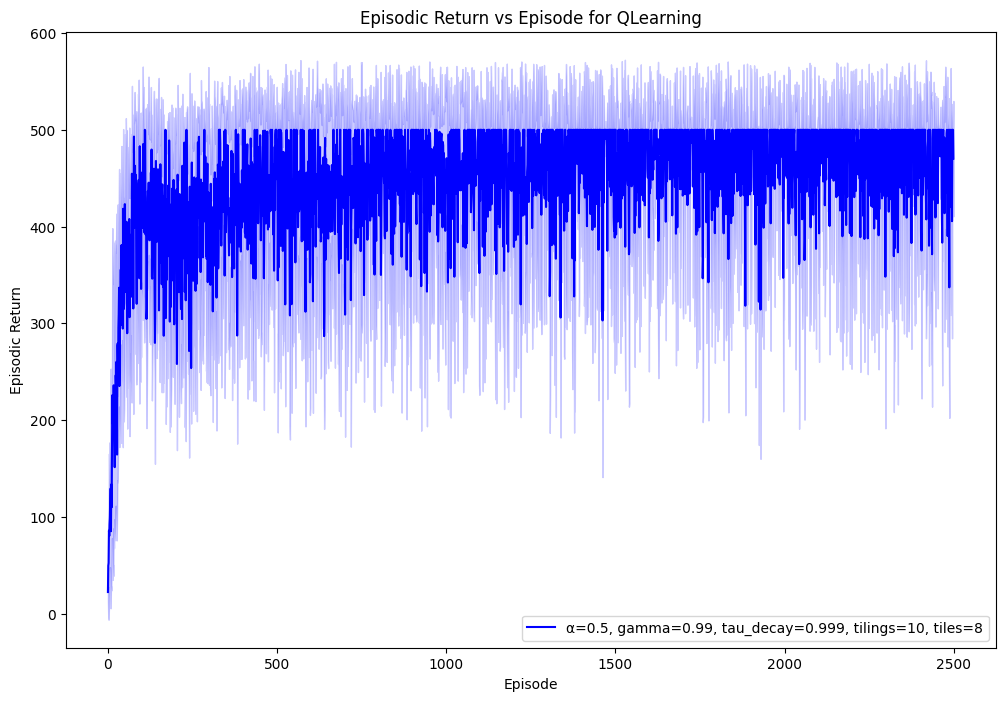

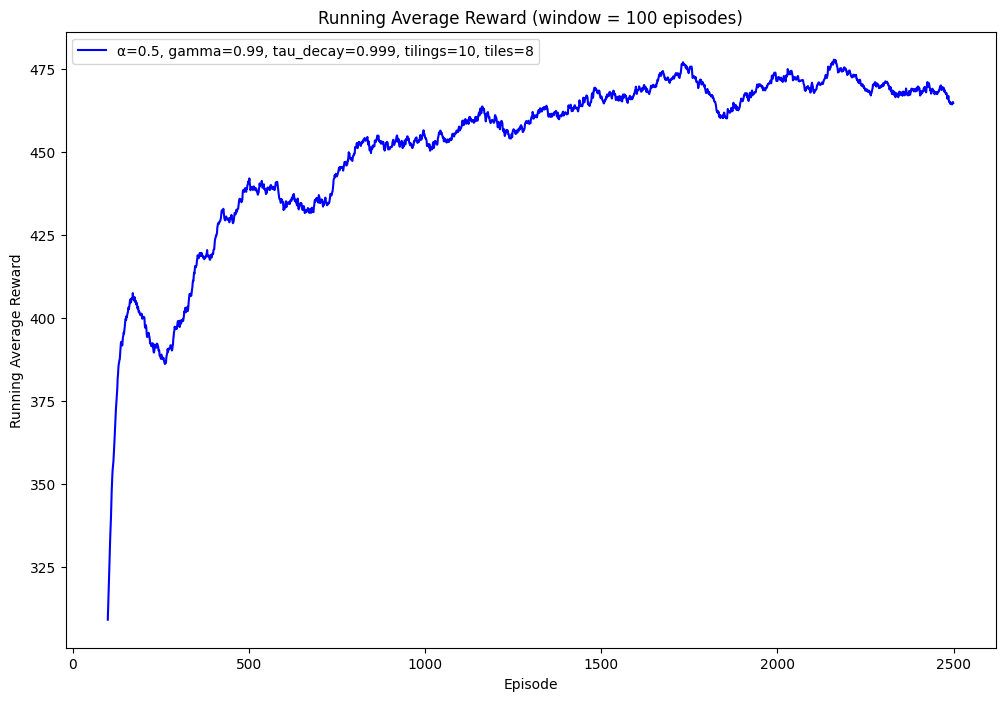

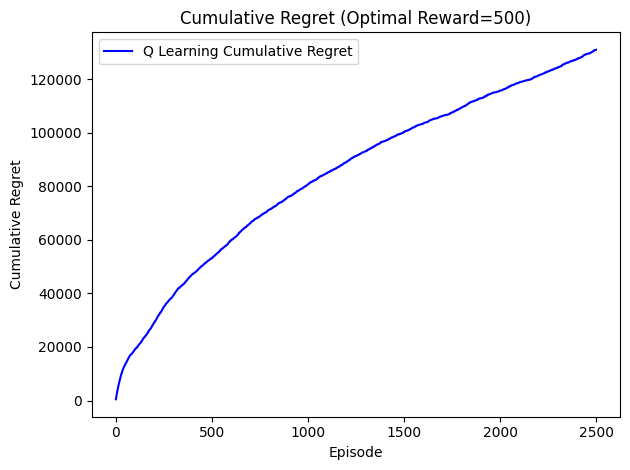

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Define legend labels for clarity (customize as needed)
labels = [
    "α=0.5, gamma=0.99, tau_decay=0.999, tilings=10, tiles=8",
    "α=0.5, gamma=0.99, tau_decay=0.995, tilings=10, tiles=8",
    "α=0.1, gamma=0.99, tau_decay=0.999, tilings=10, tiles=8",
    "α=0.5, gamma=0.99, tau_decay=0.995, tilings=5, tiles=4",
    "α=0.5, gamma=0.99, tau_decay=0.995, tilings=5, tiles=2"
]

colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each configuration

indices = [0,1,2,3,4]
# rewards = qLearning_rewards
rewards = [qLearning_rewards[i] for i in indices]
plt.figure(figsize=(12, 8))
# Compute mean and std across seeds for each episode
mean_rewards = np.mean(rewards, axis=0)
std_rewards = np.std(rewards, axis=0)
episodes = np.arange(len(mean_rewards))

# Plot mean line
plt.plot(episodes, mean_rewards, color=colors[0], label=labels[0])
# Plot shaded region for mean ± std
plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards,
                  color=colors[0], alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Episodic Return")
plt.title("Episodic Return vs Episode for QLearning")
plt.legend()
plt.show()


# Plot 2: Running Average Reward
# Here we use a moving average window (e.g., 100 episodes)

# plot for different alpha
window = 100
running_avg = []
plt.figure(figsize=(12, 8))
mean_rewards = np.mean(rewards, axis=0)
# Compute running average via convolution
running_avg = np.convolve(mean_rewards, np.ones(window)/window, mode='valid')
episodes = np.arange(window - 1, len(mean_rewards))

plt.plot(episodes, running_avg, color=colors[0], label=labels[0])
plt.xlabel("Episode")
plt.ylabel("Running Average Reward")
plt.title(f"Running Average Reward (window = {window} episodes)")
plt.legend()
plt.show()

# Plot 3: Cumulative Regret
#  We assume an optimal reward of 500 per episode.
optimal_reward = 500
mean_rewards_qLearning = np.mean(rewards, axis=0)
instant_regret_qLearning = optimal_reward - mean_rewards_qLearning
cumulative_regret_qLearning = np.cumsum(instant_regret_qLearning)
episodes = np.arange(len(cumulative_regret_qLearning))

plt.plot(episodes, cumulative_regret_qLearning, label="Q Learning Cumulative Regret", color="blue")
plt.xlabel("Episode")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret (Optimal Reward=500)")
plt.legend()

plt.tight_layout()
plt.show()

In [90]:
# Load from Excel
qlearning_rewards_df = pd.read_excel("qlearning_rewards_4.xlsx")

# Convert back to NumPy array (removing "Seed" column)
qLearning_rewards_4 = qlearning_rewards_df.drop(columns=["Seed"]).values

print("Loaded Q-Learning rewards shape:", qLearning_rewards.shape)  # Should be (num_seeds, num_episodes)

Loaded Q-Learning rewards shape: (5, 2500)


In [91]:
# Load from Excel
qlearning_rewards_df = pd.read_excel("qlearning_rewards_5.xlsx")

# Convert back to NumPy array (removing "Seed" column)
qLearning_rewards_5 = qlearning_rewards_df.drop(columns=["Seed"]).values

print("Loaded Q-Learning rewards shape:", qLearning_rewards_5.shape)  # Should be (num_seeds, num_episodes)

Loaded Q-Learning rewards shape: (5, 2500)


In [92]:
qLearning_rewards_5

array([[ 10,  14,  14, ..., 207, 187, 200],
       [ 11,  12,  30, ..., 220, 154, 219],
       [ 10,  12,  10, ...,  22,  22,  24],
       [ 37,  61,  66, ..., 293, 402, 441],
       [ 15,  40,  12, ...,  34,  34,  30]])

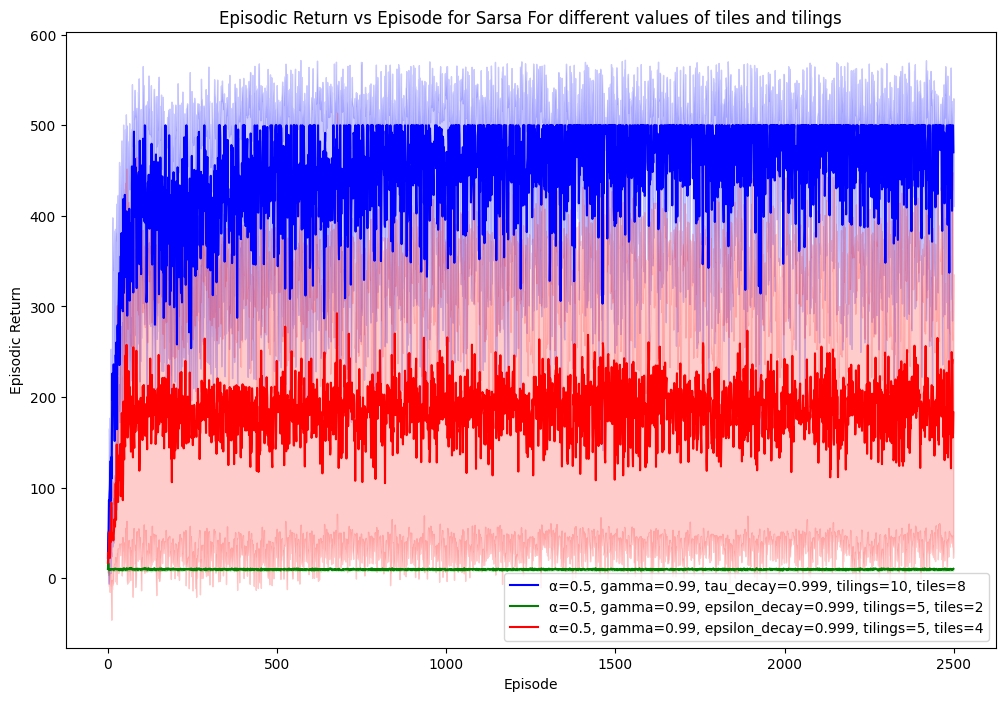

In [93]:
# plot for different values of tiles and tilings

qL1 = [qLearning_rewards,qLearning_rewards_4,qLearning_rewards_5]
plt.figure(figsize=(12, 8))
labels[1] = ["α=0.5, gamma=0.99, epsilon_decay=0.999, tilings=5, tiles=2"]
labels[2] = ["α=0.5, gamma=0.99, epsilon_decay=0.999, tilings=5, tiles=4"]

for i,rewards in enumerate(qL1):
  # Compute mean and std  across seeds for each episode
  mean_rewards = np.mean(rewards, axis=0)
  std_rewards = np.std(rewards, axis=0)
  episodes = np.arange(len(mean_rewards))

  # Plot mean line
  plt.plot(episodes, mean_rewards, color=colors[i], label=labels[i])
  # Plot shaded region for mean ± std
  plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards,
                    color=colors[i], alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Episodic Return")
plt.title("Episodic Return vs Episode for Sarsa For different values of tiles and tilings")
plt.legend()
plt.show()